In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy.linalg as jla
import jax
import matplotlib.pyplot as plt
from jax import vmap
from jax import random
import numpy as np
import optax
import time
import pandas as pd
import math
from jax import grad
import matplotlib.cm as cm  # For distinct colors

# ========================================
# Part 1: Control System Model (PIC + SLM)
# ========================================

# Constants and Parameters
def calculate_Omega_rabi_prefactor(I_mW_per_cm2, Detuning_MHz):
    """
    Calculate the effective Rabi frequency prefactor (MHz) based on laser intensity and detuning.

    Parameters:
    - I_mW_per_cm2: Laser intensity in mW/cm²
    - Detuning_MHz: Detuning in MHz

    Returns:
    - Omega_effRabi_prefactor_MHz: Effective Rabi frequency prefactor in MHz
    """
    hbar = 1.0545718e-34  # Reduced Planck constant (J·s)
    c = 3e8  # Speed of light in vacuum (m/s)
    epsilon_0 = 8.854187817e-12  # Permittivity of free space (F/m)
    mu0e = 3.336e-29  # |0> <-> |e> (C·m)
    mu1e = 3.400e-29  # |1> <-> |e> (C·m)

    I = I_mW_per_cm2 * 10  # Convert intensity from mW/cm² to W/m²
    E_0 = jnp.sqrt(2 * I / (c * epsilon_0))  # Electric field in V/m
    Omega_0e_prefactor = (mu0e * E_0) / hbar
    Omega_1e_prefactor = (mu1e * E_0) / hbar
    Omega_effRabi_prefactor = (Omega_0e_prefactor * Omega_1e_prefactor) / (2 * Detuning_MHz * 1e6)
    Omega_effRabi_prefactor_MHz = Omega_effRabi_prefactor / 1e6  # Convert to MHz
    return Omega_effRabi_prefactor_MHz


# Grid and atom positions
def generate_grid(grid_size=600, grid_range=(-6, 6)):
    """
    Generates a 2D grid using meshgrid for atom positioning.

    Args:
    grid_size (int): Number of points on the grid (default is 600).
    grid_range (tuple): Range of x and y coordinates (default is (-6, 6)).

    Returns:
    X, Y: Meshgrid for the x and y coordinates.
    """
    x = jnp.linspace(grid_range[0], grid_range[1], grid_size - 1)
    y = jnp.linspace(grid_range[0], grid_range[1], grid_size - 1)
    X, Y = jnp.meshgrid(x, y)
    return X, Y

# triangular-shaped (3-qubit encoding, "PHYS. REV. X 12, 021049 (2022)")
def generate_atom_positions_equilateral(N_a, side_length=3.0, center=(0, 0), triangle_spacing_factor=2.0):
    """
    Generate atom positions for any integer number of atoms (N_a) in equilateral triangular patterns.

    Parameters:
    - N_a (int): Total number of atoms.
    - side_length (float): Length of each side of the equilateral triangle.
    - center (tuple): Center of the first triangle (x_center, y_center).
    - triangle_spacing_factor (float): Distance between triangle centers, as a multiple of side_length.

    Returns:
    - positions (list of tuples): List of (x, y) positions for the atoms.
    """
    positions = []
    x_center, y_center = center  # Center of the first triangle
    height = (math.sqrt(3) / 2) * side_length  # Height of the equilateral triangle

    # Generate complete triangles
    num_full_triangles = N_a // 3
    for triangle_idx in range(num_full_triangles):
        # Calculate the center for the current triangle
        current_x_center = x_center + triangle_idx * triangle_spacing_factor * side_length
        current_y_center = y_center

        # Place atoms at the corners of the equilateral triangle
        positions.append((current_x_center - side_length / 2, current_y_center - height / 2))  # Bottom left
        positions.append((current_x_center + side_length / 2, current_y_center - height / 2))  # Bottom right
        positions.append((current_x_center, current_y_center + height / 2))  # Top vertex

    # Place remaining atoms (if any)
    remaining_atoms = N_a % 3
    if remaining_atoms > 0:
        # Get the last triangle's center
        if num_full_triangles > 0:
            last_x_center = x_center + (num_full_triangles - 1) * triangle_spacing_factor * side_length
            last_y_center = y_center
        else:
            last_x_center = x_center
            last_y_center = y_center

        # Add remaining atoms sequentially around the last triangle
        if remaining_atoms >= 1:
            positions.append((last_x_center - side_length / 2, last_y_center - height / 2))  # Bottom left
        if remaining_atoms == 2:
            positions.append((last_x_center + side_length / 2, last_y_center - height / 2))  # Bottom right

    return positions

# Dipoles for each atom
def generate_dipoles(N_a):
    dipoles = [jnp.array([1.0, 0]) for _ in range(N_a)]
    return dipoles

# Function to generate SLM modulations
def generate_slm_mod(N_slm):
    phase_mod = jnp.zeros(N_slm)
    amp_mod = jnp.ones(N_slm)
    return phase_mod, amp_mod

# Functions for crosstalk model setup (with fabrication variations considered)
def generate_distances(num_channels, pitch, random_variation=0.0, seed=None):
    """
    Generate pairwise distances for waveguides arranged in a linear layout with optional randomness.

    Parameters:
        num_channels (int): Number of waveguides.
        pitch (float): Spacing between adjacent waveguides (µm).
        random_variation (float): Maximum random variation (±) for distances.
        seed (int or None): Seed for reproducibility of randomness.

    Returns:
        jax.numpy.array: Pairwise distances matrix (µm).
    """
    if seed is not None:
        np.random.seed(seed)

    distances = np.zeros((num_channels, num_channels), dtype=np.float32)
    for i in range(num_channels):
        for j in range(num_channels):
            if i != j:
                # Add randomness to the calculated distance
                base_distance = abs(i - j) * pitch
                variation = np.random.uniform(-random_variation, random_variation)
                distances[i, j] = base_distance + variation
    return jnp.array(distances)

def generate_coupling_lengths(num_channels, base_length, scaling_factor=1.0, random_variation=0.0, seed=None):
    """
    Generate coupling lengths with optional randomness.

    Parameters:
        num_channels (int): Number of waveguides.
        base_length (float): Base coupling length for adjacent waveguides (µm).
        scaling_factor (float): Multiplier to scale coupling length with increasing separation.
        random_variation (float): Maximum random variation (±) for coupling lengths.
        seed (int or None): Seed for reproducibility of randomness.

    Returns:
        jax.numpy.array: Coupling lengths matrix (µm).
    """
    if seed is not None:
        np.random.seed(seed)

    coupling_lengths = np.zeros((num_channels, num_channels), dtype=np.float32)
    for i in range(num_channels):
        for j in range(num_channels):
            if i != j:
                base_length_ij = base_length * (scaling_factor**abs(i - j))
                variation = np.random.uniform(-random_variation, random_variation)
                coupling_lengths[i, j] = base_length_ij + variation
    return jnp.array(coupling_lengths)

def generate_n_eff_list(num_channels, base_n_eff, random_variation=0.0, seed=None):
    """
    Generate an array of effective refractive indices with optional randomness.

    Parameters:
        num_channels (int): Number of waveguides.
        base_n_eff (float): Base effective refractive index for all waveguides.
        random_variation (float): Maximum random variation (±) around the base value.
        seed (int or None): Seed for reproducibility of randomness.

    Returns:
        numpy.ndarray: Array of effective refractive indices (n_eff_list).
    """
    if seed is not None:
        np.random.seed(seed)

    variations = np.random.uniform(-random_variation, random_variation, num_channels)
    n_eff_list = base_n_eff + variations
    return jnp.array(n_eff_list)


# construct V(t) for classical no-OQC
def construct_V_no_qoc_with_carrier(tmin, tmax, t_steps, amplitude, center, width, omega_c, phi=0):
    """
    Constructs a classical Gaussian control pulse modulated by a carrier frequency.

    Parameters:
    - tmin (float): Start time of the pulse.
    - tmax (float): End time of the pulse.
    - t_steps (int): Number of time steps.
    - amplitude (float): Maximum amplitude of the Gaussian pulse.
    - center (float): Center of the Gaussian pulse in time.
    - width (float): Standard deviation (spread) of the Gaussian pulse in time.
    - omega_c (float): Carrier angular frequency (rad/s).
    - phi (float, optional): Initial phase of the carrier. Default is 0.

    Returns:
    - V_t (jax.numpy.array): Gaussian control pulse modulated by a carrier frequency.
    """

    time_points = jnp.linspace(tmin, tmax, t_steps)
    gaussian_envelope = amplitude * jnp.exp(-((time_points - center)**2) / (2 * width**2))
    carrier_modulation = jnp.cos(omega_c * time_points + phi)
    V_t = gaussian_envelope # * carrier_modulation

    return V_t

# PIC dual-ring- Modulator related model functions
def dn(V):
    return 4e-5 * V

def phi_func(L, n, dn_val, lambda_):
    return 2 * jnp.pi * L * (n + dn_val) / lambda_

def D_func(a, t_val, phi_val):
    return jnp.exp(1j * jnp.pi) * (a - t_val * jnp.exp(-1j * phi_val)) / (1 - t_val * a * jnp.exp(-1j * phi_val))

def U_drmzm_single_channel(V0, V1, L, n0, lambda_0, a0, t0, a1, t1, psi_0=0):
    dn_0 = dn(V0)
    dn_1 = dn(V1)
    phi0 = phi_func(L, n0, dn_0, lambda_0)
    phi1 = phi_func(L, n0, dn_1, lambda_0)

    D_00 = D_func(a0, t0, phi0) * jnp.exp(psi_0)
    D_11 = D_func(a1, t1, phi1)

    U_drmzm_matrix = jnp.array([[D_00, jnp.zeros_like(D_00)], [jnp.zeros_like(D_11), D_11]])
    U_bs = (1 / jnp.sqrt(2)) * jnp.array([[1, 1], [1, -1]])
    U_total = jnp.dot(U_bs, jnp.dot(U_drmzm_matrix, U_bs))

    return U_total

# construct multi-channel Upic with Crosstalk
def U_drmzm_multi_channel(
    V0_t_list, V1_t_list, L, n0, lambda_0, a0, t0, a1, t1,
    N_ch, distances, coupling_lengths, n_eff_list, kappa0, alpha, enable_crosstalk=True
):
    """
    Constructs the multi-channel unitary matrix with optional inter-channel coupling (amplitude and phase crosstalk).

    Parameters:
    V0_t_list, V1_t_list: Control voltages for each channel.
    L, n0, lambda_0, a0, t0, a1, t1: Physical parameters of the system.
    N_ch (int): Number of waveguides (channels).
    distances (jax.numpy.array): Pairwise distances between channels (µm).
    coupling_lengths (jax.numpy.array): Pairwise coupling lengths (µm).
    n_eff_list (jax.numpy.array): Effective refractive indices for each waveguide.
    kappa0 (float): Maximum coupling coefficient.
    alpha (float): Decay rate of coupling with distance.
    enable_crosstalk (bool): If False, disables all crosstalk and returns a diagonal matrix.

    Returns:
    U_multi_channel_with_ct: Combined unitary matrix including (or excluding) crosstalk effects.
    """
    # Step 1: Construct U_multi_channel_no_ct (diagonal matrix without crosstalk)
    U_multi_channel_no_ct = jnp.zeros((N_ch, N_ch), dtype=jnp.complex64)
    for i in range(N_ch):
        V0_t = V0_t_list[i]
        V1_t = V1_t_list[i]
        U_single_channel = U_drmzm_single_channel(V0_t, V1_t, L, n0, lambda_0, a0, t0, a1, t1)
        U_multi_channel_no_ct = U_multi_channel_no_ct.at[i, i].set(U_single_channel[0, 0])

    # If crosstalk is disabled, return the diagonal matrix only
    if not enable_crosstalk:
        return U_multi_channel_no_ct

    # Step 2: Initialize crosstalk matrix
    U_wg_coupling_ct = jnp.eye(N_ch, dtype=jnp.complex64)  # Identity matrix

    # Wave vector (k = 2π / λ)
    k = 2 * jnp.pi / lambda_0

    def compute_transfer_matrix(L_val, beta_1, beta_2, kappa):
        """Compute transfer matrix for two coupled waveguides."""
        delta_beta = (beta_1 - beta_2) / 2.0
        kappa_eff = jnp.sqrt(kappa**2 + delta_beta**2)  # Effective coupling coefficient
        cos_term = jnp.cos(kappa_eff * L_val)
        sin_term = jnp.sin(kappa_eff * L_val)
        delta_term = delta_beta / kappa_eff if kappa_eff != 0 else 0

        return jnp.array([
            [cos_term - 1j * delta_term * sin_term, -1j * sin_term],
            [-1j * sin_term, cos_term + 1j * delta_term * sin_term]
        ])

    # Step 3: Compute direct coupling contributions
    for i in range(N_ch):
        beta_i = k * n_eff_list[i]
        for j in range(i + 1, N_ch):  # Upper triangle only
            beta_j = k * n_eff_list[j]

            if distances[i, j] > 0:
                # Compute coupling coefficient and propagation length
                kappa_ij = kappa0 * jnp.exp(-alpha * distances[i, j])
                L_ij = coupling_lengths[i, j]

                # Compute transfer matrix
                M = compute_transfer_matrix(L_ij, beta_i, beta_j, kappa_ij)

                # Update crosstalk matrix with amplitude and phase contributions
                U_wg_coupling_ct = U_wg_coupling_ct.at[i, j].set(M[0, 1])
                U_wg_coupling_ct = U_wg_coupling_ct.at[j, i].set(jnp.conj(M[0, 1]))

    # Step 4: Calculate combined matrix with crosstalk
    U_multi_channel_with_ct = jnp.matmul(U_multi_channel_no_ct, U_wg_coupling_ct)

    return U_multi_channel_with_ct

# construct U_SLM and weak scattering matrix
def construct_U_multi_channel_slm(N_slm, phase_mod, amp_mod, t_steps):
    U_slm = jnp.zeros((t_steps, N_slm, N_slm), dtype=jnp.complex64)
    for t in range(t_steps):
        for i in range(N_slm):
            phase = jnp.exp(1j * phase_mod[i])
            amplitude = amp_mod[i]
            U_slm = U_slm.at[t, i, i].set(amplitude * phase)
    return U_slm

def construct_I_prime(N_scat, delta, t_steps):
    I_prime = jnp.zeros((t_steps, N_scat, N_scat), dtype=jnp.complex64)
    for t in range(t_steps):
        I_prime = I_prime.at[t].set(jnp.eye(N_scat) + jnp.diag(jnp.full(N_scat, delta)))
    return I_prime

# construct projected E-field profile on atom plane
def lg00_mode_profile(X, Y, beam_center, beam_waist):
    cx, cy = beam_center
    r_squared = (X - cx)**2 + (Y - cy)**2
    E_profile = jnp.exp(-r_squared / (2 * beam_waist**2))
    return E_profile

def compute_E_field_for_channel(X, Y, E_t, beam_center, beam_waist, t_idx):
    E_profile = lg00_mode_profile(X, Y, beam_center, beam_waist)
    E_field = E_profile * (jnp.real(E_t) + 1j * jnp.imag(E_t))  # Corrected indexing
    return E_field

def compute_total_E_field_profile(X, Y, b_slm_out, beam_centers, beam_waist):
    E_field_profiles = []
    for t_idx in range(b_slm_out.shape[0]):
        E_field_total = jnp.zeros_like(X, dtype=jnp.complex64)
        for atom_index, beam_center in enumerate(beam_centers):
            E_field_total += compute_E_field_for_channel(X, Y, b_slm_out[t_idx, atom_index], beam_center, beam_waist, t_idx)
        E_field_profiles.append(E_field_total)
    return jnp.array(E_field_profiles)

# extract complex-valued E-field at each atom qubit location
def extract_E_field_at_atoms(E_field_profiles, atom_positions, X, Y):
    E_field_at_atoms = []

    for t_idx in range(E_field_profiles.shape[0]):
        E_field_at_timestep = []
        for x0, y0 in atom_positions:
            x_idx = jnp.argmin(jnp.abs(X[0, :] - x0))
            y_idx = jnp.argmin(jnp.abs(Y[:, 0] - y0))
            E_field_at_timestep.append(E_field_profiles[t_idx][y_idx, x_idx])
        E_field_at_atoms.append(jnp.array(E_field_at_timestep))
    return jnp.array(E_field_at_atoms)

# compute effective Rabi freq (t) for each atom qubit
def compute_alpha_t(E_fields_at_atoms, dipoles, Omega_prefactor_MHz):
    alpha_t = []
    for t_idx in range(E_fields_at_atoms.shape[0]):
        alpha_t_timestep = []
        for atom_idx in range(len(dipoles)):
            E_field_atom = E_fields_at_atoms[t_idx, atom_idx]
            dipole = dipoles[atom_idx]
            alpha_t_timestep.append(Omega_prefactor_MHz * dipole[0] * E_field_atom)
        alpha_t.append(jnp.array(alpha_t_timestep))
    return jnp.array(alpha_t)


# ========================================
# Part 2: Atomic Model
# ========================================

# Two levels per qubit
N_qubit_level = 2

# Define multi-qubit operators and Hamiltonians (as described previously)
s_plus = jnp.array([[0, 1], [0, 0]], dtype=jnp.complex64)
s_minus = jnp.array([[0, 0], [1, 0]], dtype=jnp.complex64)
s_z = jnp.array([[1, 0], [0, -1]], dtype=jnp.complex64)

def construct_multi_qubit_operator(single_qubit_op, N_a, N_qubit_level, qubit_idx):
    I = jnp.eye(N_qubit_level, dtype=jnp.complex64)
    op_list = [I] * N_a
    op_list[qubit_idx] = single_qubit_op

    multi_qubit_op = op_list[0]
    for op in op_list[1:]:
        multi_qubit_op = jnp.kron(multi_qubit_op, op)

    return multi_qubit_op

# Creation and annihilation operators for the quantized field (Fock mode)
def construct_annihilation_operator(fock_dim):
    a = jnp.zeros((fock_dim, fock_dim), dtype=jnp.complex64)
    for n in range(1, fock_dim):
        a = a.at[n - 1, n].set(jnp.sqrt(n))
    a_dag = a.T.conj()  # Creation operator is the Hermitian conjugate of annihilation operator
    return a, a_dag

# Fock space dimensions
fock_dim = 5
a, a_dag = construct_annihilation_operator(fock_dim)
I_fock = jnp.eye(fock_dim, dtype=jnp.complex64)

# Drift Hamiltonian (H_0)
def construct_H_0(N_a, omega_0, omega_r):  # omega_0/r in MHz
    H_0_qubits = sum(0.5 * omega_0 * construct_multi_qubit_operator(s_z, N_a, 2, i) for i in range(N_a))
    H_0_field = omega_r * jnp.kron(jnp.eye(2 ** N_a), a_dag @ a)
    return jnp.kron(H_0_qubits, I_fock) + H_0_field

# Control Hamiltonian
def construct_H_control(N_a, N_qubit_level, g_real_t, g_imag_t):
    H_control = jnp.zeros((N_qubit_level ** N_a * fock_dim, N_qubit_level ** N_a * fock_dim), dtype=jnp.complex64)
    for i in range(N_a):
        H_control += g_real_t[i] * (jnp.kron(construct_multi_qubit_operator(s_plus, N_a, N_qubit_level, i), a) +
                                    jnp.kron(construct_multi_qubit_operator(s_minus, N_a, N_qubit_level, i), a_dag))
        H_control += g_imag_t[i] * (1j * jnp.kron(construct_multi_qubit_operator(s_plus, N_a, N_qubit_level, i), a) -
                                    1j * jnp.kron(construct_multi_qubit_operator(s_minus, N_a, N_qubit_level, i), a_dag))
    return H_control

# Time Evolution Hamiltonian (H(t))
def construct_H_time(N_a, N_qubit_level, omega_0, omega_r, g_real_t, g_imag_t,
                   atom_positions, gate_type='single'):
    """Construct the time-dependent Hamiltonian H(t) as a JAX array."""
    H_t_list = []  # Store Hamiltonians for each time step

    # Construct base Hamiltonians
    H_0 = construct_H_0(N_a, omega_0, omega_r)

    # Construct H(t) for each time step
    for t in range(len(g_real_t)):
        H_control = construct_H_control(N_a, N_qubit_level, g_real_t[t], g_imag_t[t])
        H_t = H_0 + H_control
        H_t_list.append(H_t)

    # Convert list of Hamiltonians to a JAX array
    return jnp.array(H_t_list)

# Compute accumulated propagator (U(t)) over time
def compute_accumulated_propagator(H_t, dt, N_a, N_qubit_level):
    dim = N_qubit_level ** N_a * fock_dim
    U_accumulated = jnp.eye(dim, dtype=jnp.complex64)
    U_t_all = []
    for H in H_t:
        U_t = jla.expm(-1j * H * dt)
        U_accumulated = U_t @ U_accumulated
        U_t_all.append(U_accumulated)
    return jnp.array(U_t_all)

# Trace out field from unitary matrix
def trace_out_field_from_unitary(U_t, N_a, N_qubit_level, field_dim=5):
    dim_qubits = N_qubit_level ** N_a
    U_t_reshaped = U_t.reshape(dim_qubits, field_dim, dim_qubits, field_dim)
    U_t_traced = jnp.sum(U_t_reshaped, axis=(1, 3))
    return U_t_traced


# calculate F(T)
def compute_fidelity_unitary(U_t_traced, U_target):
    """
    Computes the fidelity of the unitary evolution compared to the target unitary
    using the standard multi-qubit gate fidelity formula.

    Parameters:
    - U_t_traced: Reduced unitary matrix for the qubit system after tracing out the field.
    - U_target: Target unitary matrix.

    Returns:
    - fidelity: The fidelity between the evolved and target unitary matrices.
    """
    # Dimension of the Hilbert space
    d = U_target.shape[0]  # For N qubits, d = 2^N

    # Compute fidelity using the standard formula
    trace_overlap = jnp.abs(jnp.trace(U_target.conj().T @ U_t_traced))**2
    fidelity = trace_overlap / (d**2)

    return jnp.real(fidelity)


# Clifford gates
def clifford_group_and_t_gate():
    H = (1 / jnp.sqrt(2)) * jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64)
    S = jnp.array([[1, 0], [0, 1j]], dtype=jnp.complex64)
    X = jnp.array([[0, 1], [1, 0]], dtype=jnp.complex64)
    T = jnp.array([[1, 0], [0, jnp.exp(1j * jnp.pi / 4)]], dtype=jnp.complex64)

    return [
        ("H", H),
        ("S", S),
        ("X", X),
        ("T", T),
    ]

# ========================================
# Part 3: Function to Compute Gate Fidelity
# ========================================

def compute_multi_qubit_fidelity_closed_system(
    V0_t_list, V1_t_list, L, n0, lambda_0, a0, t0, a1, t1, phase_mod, amp_mod, delta,
    atom_positions, dipoles, beam_centers, beam_waist, X, Y, Omega_prefactor_MHz,
    tmin, tmax_fixed, t_steps, dt,
    N_ch, distances, coupling_lengths, n_eff_list, kappa0, alpha, enable_crosstalk,
    N_slm, N_ch_slm_in, N_scat_1, N_scat_2, N_a, N_qubit_level, omega_0, omega_r, a_pic, a_scat_1,
    U_target, gate_type='single'
):
    """
    Computes the multi-qubit fidelity for a closed system with a fixed tmax.

    Parameters:
        V0_t_list, V1_t_list: Control voltage time-series for each channel.
        L, n0, lambda_0, a0, t0, a1, t1: Physical parameters of the MZM.
        phase_mod, amp_mod: Phase and amplitude modulation parameters.
        delta: Detuning.
        atom_positions, dipoles: Atom positions and dipole moments.
        beam_centers, beam_waist: Parameters of the spatial light modulator (SLM).
        X, Y: 2D grid for the beam field.
        Omega_prefactor_MHz: Prefactor for Rabi frequency in MHz.
        tmin, tmax_fixed, t_steps, dt: Time parameters.
        N_ch: Number of photonic channels.
        distances: Pairwise distances between channels (µm).
        coupling_lengths: Pairwise coupling lengths (µm).
        n_eff_list: Effective refractive indices for the waveguides.
        kappa0, alpha: Crosstalk parameters.
        enable_crosstalk (bool): If False, crosstalk is disabled.
        N_slm, N_ch_slm_in, N_scat_1, N_scat_2, N_a, N_qubit_level: System configuration.
        omega_0, omega_r: Frequencies in MHz.
        a_pic, a_scat_1: Initial fields.
        U_target: Target unitary matrix.
        gate_type: Type of quantum gate ('single', 'multi', etc.).

    Returns:
        Fidelity of the computed unitary matrix with respect to the target matrix.
    """
    # Compute Unitary Matrix for Multi-Channel System
    U_system_multi_channel = jnp.array([
        U_drmzm_multi_channel(
            [V0_t[i] for V0_t in V0_t_list],
            [V1_t[i] for V1_t in V1_t_list],
            L, n0, lambda_0, a0, t0, a1, t1,
            N_ch, distances, coupling_lengths, n_eff_list,
            kappa0, alpha, enable_crosstalk
        )
        for i in range(t_steps)
    ])

    # Compute scattering and SLM matrices
    I1_prime = construct_I_prime(N_scat_1, delta, t_steps)
    U_tensor_product = jnp.array([jnp.kron(U_system_multi_channel[i], I1_prime[i]) for i in range(t_steps)])

    # Output modes calculations
    a_total = jnp.kron(a_pic, a_scat_1)
    output_modes = jnp.array([jnp.dot(U_tensor_product[i], a_total) for i in range(t_steps)])
    output_modes_reshaped = output_modes.reshape(t_steps, N_ch, N_scat_1)
    a_pic_out = jnp.sum(output_modes_reshaped, axis=-1)
    a_scat_1_out = jnp.sum(output_modes_reshaped, axis=-2)

    # Compute final output modes after SLM and second scattering
    b_slm_in = jnp.zeros((t_steps, N_slm), dtype=jnp.complex64)
    b_scat2_in = jnp.zeros((t_steps, N_scat_2), dtype=jnp.complex64)

    for t in range(t_steps):
        b_slm_in = b_slm_in.at[t, :N_ch_slm_in].set(a_pic_out[t, :N_ch_slm_in])
        b_slm_in = b_slm_in.at[t, N_ch_slm_in:].set(a_scat_1_out[t, :(N_slm - N_ch_slm_in)])

        b_scat2_in = b_scat2_in.at[t, :(N_ch - N_ch_slm_in)].set(a_pic_out[t, N_ch_slm_in:])
        b_scat2_in = b_scat2_in.at[t, (N_ch - N_ch_slm_in):].set(a_scat_1_out[t, (N_scat_2 - (N_ch - N_ch_slm_in)):])

    b_total_in = jnp.array([jnp.kron(b_slm_in[t], b_scat2_in[t]) for t in range(t_steps)])
    U_multi_channel_slm = construct_U_multi_channel_slm(N_slm, phase_mod, amp_mod, t_steps)
    I2_prime = construct_I_prime(N_scat_2, delta, t_steps)
    U_tensor_product_stage_2 = jnp.array([jnp.kron(U_multi_channel_slm[t], I2_prime[t]) for t in range(t_steps)])
    b_total_out = jnp.array([jnp.dot(U_tensor_product_stage_2[t], b_total_in[t]) for t in range(t_steps)])

    b_total_out_reshaped = b_total_out.reshape(t_steps, N_slm, N_scat_2)
    b_slm_out = jnp.sum(b_total_out_reshaped, axis=-1)

    E_field_profiles = compute_total_E_field_profile(X, Y, b_slm_out, beam_centers, beam_waist)
    E_fields_at_atoms = extract_E_field_at_atoms(E_field_profiles, atom_positions, X, Y)
    # effective Rabi for each atom
    alpha_t = compute_alpha_t(E_fields_at_atoms, dipoles, Omega_prefactor_MHz)

    # g_real_t and g_imag_t represent g(t) in the Jaynes-Cummings model, g(t) = eff_Rabi(t)/2
    g_real_t = alpha_t.real / 2
    g_imag_t = alpha_t.imag / 2

    # Construct the time-dependent Hamiltonian
    H_t = construct_H_time(N_a, N_qubit_level, omega_0, omega_r, g_real_t, g_imag_t, atom_positions, gate_type)

    # Evolve the unitary matrix (propagator)
    U_t_all = compute_accumulated_propagator(H_t, dt, N_a, N_qubit_level)

    # Trace out the field from the final unitary matrix
    U_t_traced = trace_out_field_from_unitary(U_t_all[-1], N_a, N_qubit_level)

    # Compute fidelity with the target gate
    fidelity = compute_fidelity_unitary(U_t_traced, U_target)

    return fidelity, E_field_profiles, E_fields_at_atoms

# ========================================
# Part 4: Program Instruction function
# ========================================
def program_instruction(N_a, key_number, gate_type='single', selected_atoms=None, control_atom=None, target_atom=None):
    """
    Constructs the target gates for selected atoms. If `gate_type` is 'single', it applies single-qubit gates.
    Prints out the gate applied to each atom.
    """
    if gate_type == 'single':
        # Define the Clifford gates for single-qubit gates
        clifford_t_gates = clifford_group_and_t_gate()
        U_target_multi_qubit = []
        key = jrandom.PRNGKey(key_number)  # Initialize the random key for gate selection

        # Apply random single-qubit gates to selected atoms
        for atom_idx in range(N_a):
            if selected_atoms is None or atom_idx in selected_atoms:
                key, subkey = jrandom.split(key)  # Split key for each atom to ensure different gates
                gate_idx = jrandom.randint(subkey, (), minval=0, maxval=len(clifford_t_gates))
                gate_name, gate = clifford_t_gates[gate_idx]
                print(f"Applying {gate_name} gate to Atom {atom_idx}")
                U_target_multi_qubit.append(gate)
            else:
                print(f"Applying Identity gate to Atom {atom_idx}")
                U_target_multi_qubit.append(jnp.eye(2))  # Identity gate for unselected atoms

        # Combine the gates using the Kronecker product
        U_target = U_target_multi_qubit[0]
        for gate in U_target_multi_qubit[1:]:
            U_target = jnp.kron(U_target, gate)

        return U_target

# case 1: apply V(t) only on atom 1, no crosstalk



 --- Initial Setups --- 

tmax_fixed : 0.1 us
Crosstalk is disabled.
Atom positions: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], in [um]
Beam centers: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], Beam waist: 2.0 in [um]
Applying X gate to Atom 0
Applying Identity gate to Atom 1
Applying Identity gate to Atom 2
U_target: [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...
Simulation completed in 0.12 minutes.
fidelity: 0.26069

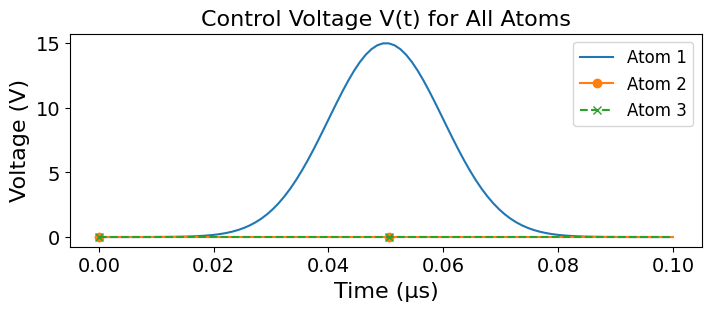

/usr/local/lib/python3.11/dist-packages/matplotlib/contour.py:1371: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/usr/local/lib/python3.11/dist-packages/matplotlib/contour.py:1372: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


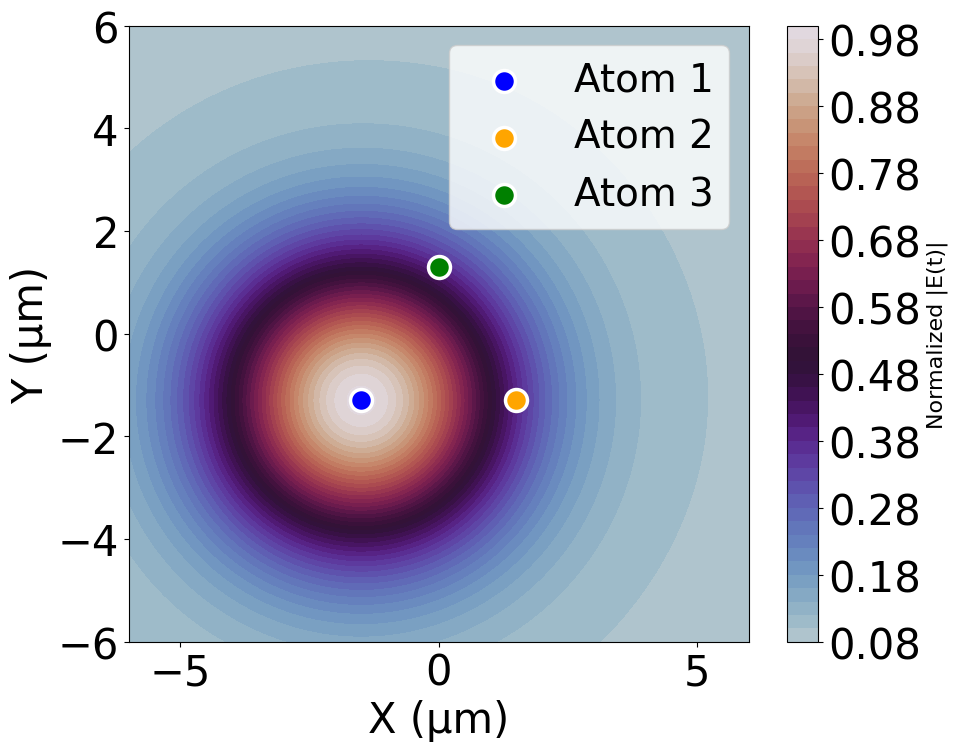

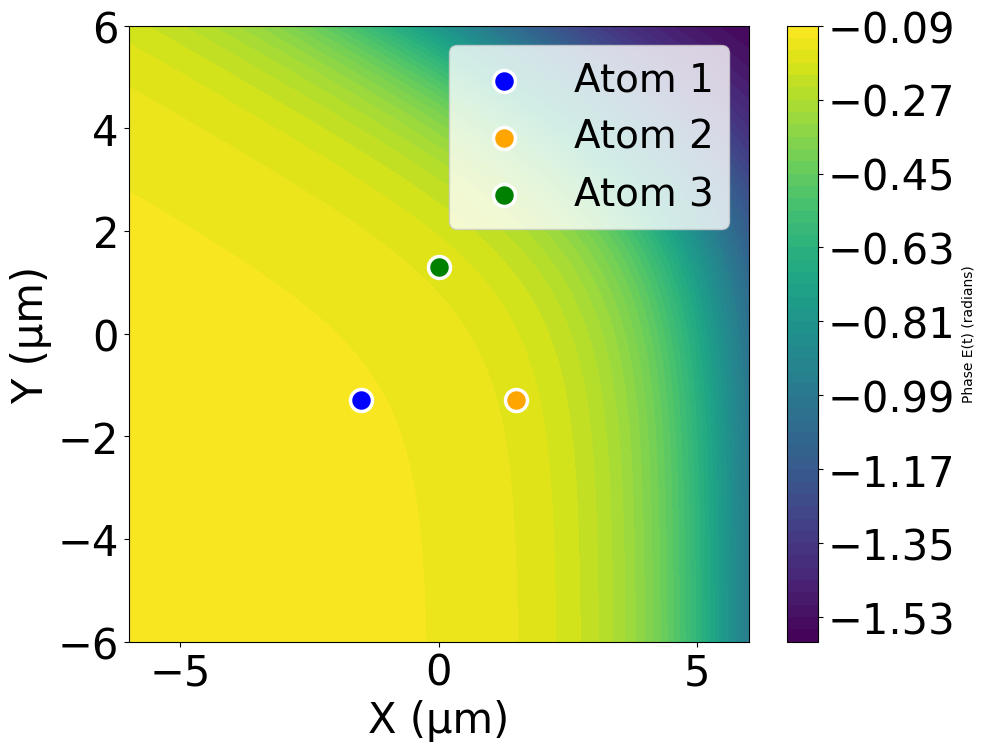

In [ ]:

# ========================================
# Part 5: main execution
# ========================================

# Main function to run the hybrid optimization
def run_multi_qubit_no_qoc():
    print(f" --- Initial Setups --- \n")

    # Laser intensity setup
    I_mW_per_cm2 = 20  # Laser intensity in mW/cm²
    Detuning_MHz = 1000  # 1 GHz detuning
    Omega_prefactor_MHz = calculate_Omega_rabi_prefactor(I_mW_per_cm2, Detuning_MHz)

    # Control system parameters
    m, n0, lambda_0 = 600, 1.95, 780e-9
    L = m * lambda_0 / n0
    a0, t0, a1, t1 = 0.998, 0.998, 0.998, 0.998

    # Define frequencies in MHz
    omega_0, omega_r = 6.835e3, 6.835e3

    # Time parameters [us]
    tmin = 0
    tmax_fixed = 0.1 #jnp.pi/30   # Fixed tmax in microseconds
    print(f"tmax_fixed : {tmax_fixed} us")
    t_steps = 100
    dt = (tmax_fixed - tmin) / t_steps

    # System and channel setup
    N_ch, N_scat_1, N_slm, N_ch_slm_in = 6, 4, 6, 4
    N_total = N_ch + N_scat_1
    N_scat_2, N_a = N_total - N_slm, 3


    # Crosstalk flag
    enable_crosstalk = False  # Set to True to enable crosstalk

    if enable_crosstalk:
        # Inter-channel waveguide distances
        base_distance = 1.0  # µm (nominal distance between adjacent waveguides)
        distance_variation = 0.1  # Random variation in distances (± µm)
        distances = generate_distances(N_ch, base_distance, random_variation=distance_variation, seed=42)

        # Coupling lengths
        base_coupling_length = 600.0  # µm (nominal coupling length for adjacent waveguides)
        length_variation = 60.0  # Random variation in coupling lengths (± µm)
        coupling_lengths = generate_coupling_lengths(N_ch, base_coupling_length, scaling_factor=1.1,
                                                      random_variation=length_variation, seed=42)

        # Effective refractive indices
        base_n_eff = 1.75  # Nominal effective refractive index
        n_eff_variation = 0.05  # Random variation in effective index (±)
        n_eff_list = generate_n_eff_list(N_ch, base_n_eff, random_variation=n_eff_variation, seed=42)

        # Waveguide-Coupling Parameters
        kappa0 = 10.145  # Maximum coupling coefficient at zero separation
        alpha = 6.934    # Coupling decay rate per µm

        print("Crosstalk parameters initialized:")
        print(f"Distances: {distances}")
        print(f"Coupling lengths: {coupling_lengths}")
        print(f"Effective refractive indices: {n_eff_list}")
        print(f"kappa0: {kappa0}, alpha: {alpha}")
    else:
        print("Crosstalk is disabled.")
        distances = None
        coupling_lengths = None
        n_eff_list = None
        kappa0 = None
        alpha = None

    # 2D atomic grid and atom positions
    atom_spacing = 3.0
    X, Y = generate_grid(grid_size=600, grid_range=(-6, 6))
    atom_positions = positions = generate_atom_positions_equilateral(N_a, side_length=atom_spacing, center=(0, 0))

    print(f"Atom positions: {atom_positions}, in [um]")

    # Beam and dipole parameters
    beam_centers, beam_waist = atom_positions, 2.0
    print(f"Beam centers: {beam_centers}, Beam waist: {beam_waist} in [um]")
    dipoles = generate_dipoles(N_a)

    # SLM modulation parameters
    phase_mod, amp_mod = generate_slm_mod(N_slm)

    # Weak scattering: pic inter-channel
    delta = 0.001

    # Control signal limits
    min_V_level, max_V_level = -15, 15

    # Initial fields
    a_pic = jnp.array([1.0] * N_ch)
    a_scat_1 = jnp.array([1.0] * N_scat_1)


    # Gaussian pulse parameters
    amplitude = 15.0  # Voltage amplitude
    center = (tmax_fixed - tmin) / 2  # Center of the pulse
    width = 0.01 # Width of the Gaussian pulse in microseconds
    omega_c = omega_0  # Carrier angular frequency

    # Select the gate type and generate target gate
    selected_atoms=[0]

    gate_type = 'single'
    if gate_type == 'single':
        U_target = program_instruction(N_a, key_number=1, gate_type=gate_type, selected_atoms=selected_atoms)

    print(f"U_target: {U_target}")

    # Amplitude scaling factors for each atom
    amplitude_scaling = [1.0, 0, 0]  # voltage scaling factors for atoms 1, 2, and 3

    # Generate control signals modulated by carrier frequency for each atom
    V0_no_qoc_list = []
    V1_no_qoc_list = []

    for atom_idx in range(N_a):  # Loop over all atoms
        V0_no_qoc = construct_V_no_qoc_with_carrier(
            tmin, tmax_fixed, t_steps, amplitude * amplitude_scaling[atom_idx], center, width, omega_c
        )
        V1_no_qoc = construct_V_no_qoc_with_carrier(
            tmin, tmax_fixed, t_steps, amplitude * amplitude_scaling[atom_idx], center, width, omega_c
        )
        V0_no_qoc_list.append(V0_no_qoc)
        V1_no_qoc_list.append(V1_no_qoc)

    # Fill the remaining channels with zero signals
    for _ in range(N_ch - N_a):  # Remaining unused channels
        V0_no_qoc_list.append(jnp.zeros(t_steps))
        V1_no_qoc_list.append(jnp.zeros(t_steps))

    # Convert lists to JAX arrays
    V0_no_qoc_list = jnp.array(V0_no_qoc_list)
    V1_no_qoc_list = jnp.array(V1_no_qoc_list)

    # Save initial control signals (optional)
    pd.DataFrame(V0_no_qoc_list).to_csv('V0_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')
    pd.DataFrame(V1_no_qoc_list).to_csv('V1_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')

    # Define parameter dictionaries
    APIC_params = {
        'L': L, 'n0': n0, 'lambda_0': lambda_0, 'a0': a0, 't0': t0,
        'a1': a1, 't1': t1, 'phase_mod': phase_mod, 'amp_mod': amp_mod
    }

    atom_beam_params = {
        'atom_positions': atom_positions, 'dipoles': dipoles,
        'a_pic': a_pic, 'a_scat_1': a_scat_1, 'beam_centers': beam_centers,
        'beam_waist': beam_waist, 'X': X, 'Y': Y, 'Omega_prefactor_MHz': Omega_prefactor_MHz,
    }

    control_Vt_params = {
        'tmin': tmin,
        'tmax': tmax_fixed,  # Fixed tmax
        't_steps': t_steps,
        'dt': dt,
        'min_V_level': min_V_level,
        'max_V_level': max_V_level
    }

    system_params = {
        'N_ch': N_ch, 'distances': distances,
        'coupling_lengths': coupling_lengths,
        'n_eff_list': n_eff_list,
        'enable_crosstalk': enable_crosstalk,
        'kappa0': kappa0, 'alpha': alpha,
        'N_slm': N_slm, 'N_ch_slm_in': N_ch_slm_in, 'N_scat_1': N_scat_1,
        'N_scat_2': N_scat_2, 'N_a': N_a, 'N_qubit_level': 2, 'omega_0': omega_0,
        'omega_r': omega_r, 'U_target': U_target, 'gate_type': gate_type, 'delta': delta
    }

    # Start optimization
    start_time = time.time()

    # classical control pulse, without QOC, use gaussian
    print("\n--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...")

    fidelity_gaussian, E_field_profiles, E_fields_at_atoms = compute_multi_qubit_fidelity_closed_system(
        V0_no_qoc_list, V1_no_qoc_list, APIC_params['L'], APIC_params['n0'],
        APIC_params['lambda_0'], APIC_params['a0'], APIC_params['t0'],
        APIC_params['a1'], APIC_params['t1'], APIC_params['phase_mod'],
        APIC_params['amp_mod'], system_params['delta'],
        atom_beam_params['atom_positions'], atom_beam_params['dipoles'],
        atom_beam_params['beam_centers'], atom_beam_params['beam_waist'],
        atom_beam_params['X'], atom_beam_params['Y'], atom_beam_params['Omega_prefactor_MHz'],
        control_Vt_params['tmin'], tmax_fixed,
        control_Vt_params['t_steps'], control_Vt_params['dt'],
        system_params['N_ch'], system_params['distances'], system_params['coupling_lengths'],
        system_params['n_eff_list'], system_params['kappa0'], system_params['alpha'],
        system_params['enable_crosstalk'],
        system_params['N_slm'], system_params['N_ch_slm_in'], system_params['N_scat_1'],
        system_params['N_scat_2'], system_params['N_a'],
        system_params['N_qubit_level'], system_params['omega_0'],
        system_params['omega_r'], atom_beam_params['a_pic'],
        atom_beam_params['a_scat_1'],
        system_params['U_target'], system_params['gate_type']
    )

    execution_time = (time.time() - start_time) / 60.0
    print(f"Simulation completed in {execution_time:.2f} minutes.")
    print(f"fidelity: {fidelity_gaussian:.10f}")

    # Time points
    time_points = jnp.linspace(tmin, tmax_fixed, t_steps)

    # Plot V(t) for all atoms in one figure
    fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)

    # Iterate through atoms and plot their V(t)
    for atom_idx in range(N_a):
        V_atom = V0_no_qoc_list[atom_idx]  # Extract the V(t) for the atom

        # Use different line styles and markers to distinguish overlapping plots
        if atom_idx == 1:  # Assuming atom 2 corresponds to index 1
            ax.plot(
                time_points,
                V_atom,
                label=f"Atom {atom_idx + 1}",
                linestyle='-',
                marker='o',
                markevery=50  # Add markers for visibility
            )
        elif atom_idx == 2:  # Assuming atom 3 corresponds to index 2
            ax.plot(
                time_points,
                V_atom,
                label=f"Atom {atom_idx + 1}",
                linestyle='--',
                marker='x',
                markevery=50  # Add markers for visibility
            )
        else:
            ax.plot(
                time_points,
                V_atom,
                label=f"Atom {atom_idx + 1}"
            )

    # Add labels, legend, and title
    ax.set_title("Control Voltage V(t) for All Atoms", fontsize=16)
    ax.set_xlabel("Time (µs)", fontsize=16)
    ax.set_ylabel("Voltage (V)", fontsize=16)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', labelsize=14)
    # ax.grid()  # Uncomment to add gridlines

    # Save and display the figure
    plt.savefig("Control_Vt_for_all_atoms_with_markers.png")
    plt.show()

    # Determine global min and max values for normalized amplitude
    E_magnitude_min = 0  # Normalized values are in [0, 1]
    E_magnitude_max = 1
    # Time indices to visualize (middle of the simulation)
    time_indices = [t_steps // 2]

    for t_idx in time_indices:
        E_profile = jnp.abs(E_field_profiles[t_idx])
        normalized_E_profile = (E_profile - jnp.min(E_field_profiles)) / (
            jnp.max(E_field_profiles) - jnp.min(E_field_profiles)
        )  # Normalize to [0, 1]

        # Normalized Magnitude profile
        plt.figure(figsize=(10, 8))
        contour = plt.contourf(
            X,
            Y,
            normalized_E_profile,
            levels=50,
            cmap="twilight", #"viridis",
            vmin=E_magnitude_min,
            vmax=E_magnitude_max,
        )
        #plt.colorbar(label="Normalized |E(t)|")
        colorbar = plt.colorbar(contour, label="Normalized |E(t)|")
        colorbar.ax.tick_params(labelsize=30)  # Adjust colorbar tick size
        colorbar.set_label("Normalized |E(t)|", fontsize=16)
        # Plot atom positions with enhanced visibility
        for i, pos in enumerate(atom_positions):
            plt.scatter(
                pos[0],
                pos[1],
                c=["blue", "orange", "green"][i % 3],  # Repeat colors for more than 3 atoms
                s=250,  # Increase marker size
                edgecolors="white",  # Add white edge
                linewidths=2.5,  # Thickness of the edge
                label=f"Atom {i + 1}",
            )

        #plt.title(f"Normalized E-field Magnitude Profile at t = {time_points[t_idx]:.2f} µs")
        plt.xlabel("X (µm)", fontsize=30)
        plt.ylabel("Y (µm)", fontsize=30)
        plt.tick_params(axis='both', labelsize=30)
        plt.legend(fontsize=28)
        plt.savefig(f"Normalized_E_field_magnitude_t{t_idx}.png")
        plt.show()

    # 3. Phase profile of E(t) at each time index (no normalization)
    for t_idx in time_indices:
        phase_profile = jnp.angle(E_field_profiles[t_idx])  # Compute phase

        plt.figure(figsize=(10, 8))
        contour = plt.contourf(X, Y, phase_profile, levels=50, cmap="viridis")
        colorbar = plt.colorbar(contour, label="Phase E(t) (radians)")
        colorbar.ax.tick_params(labelsize=30)  # Adjust colorbar tick size
        colorbar.set_label("Phase E(t) (radians)")
        # Plot atom positions with enhanced visibility
        for i, pos in enumerate(atom_positions):
            plt.scatter(
                pos[0],
                pos[1],
                c=["blue", "orange", "green"][i % 3],  # Repeat colors for more than 3 atoms
                s=250,  # Increase marker size
                edgecolors="white",  # Add white edge
                linewidths=2.5,  # Thickness of the edge
                label=f"Atom {i + 1}",
            )

        #plt.title(f"E-field Phase Profile at t = {time_points[t_idx]:.2f} µs")
        plt.xlabel("X (µm)", fontsize=30)
        plt.ylabel("Y (µm)", fontsize=30)
        plt.tick_params(axis='both', labelsize=30)
        plt.legend(fontsize=28)
        plt.savefig(f"E_field_phase_t{t_idx}.png")
        plt.show()


if __name__ == "__main__":
    run_multi_qubit_no_qoc()


# case 2: apply V(t) also on atom 2 and 3, no crosstalk


 --- Initial Setups --- 

tmax_fixed : 0.1 us
Crosstalk is disabled.
Atom positions: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], in [um]
Beam centers: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], Beam waist: 2.0 in [um]
Applying X gate to Atom 0
Applying Identity gate to Atom 1
Applying Identity gate to Atom 2
U_target: [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...
Simulation completed in 0.12 minutes.
fidelity: 0.95213

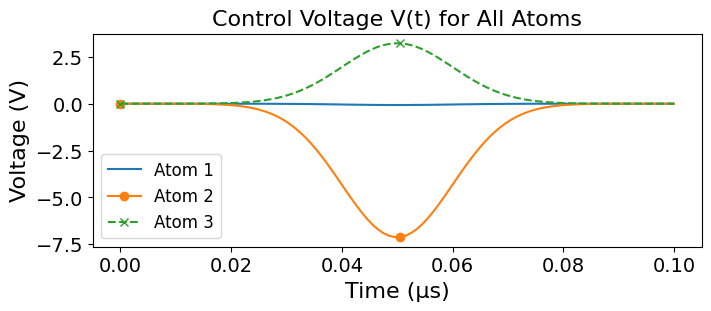

/usr/local/lib/python3.11/dist-packages/matplotlib/contour.py:1371: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/usr/local/lib/python3.11/dist-packages/matplotlib/contour.py:1372: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


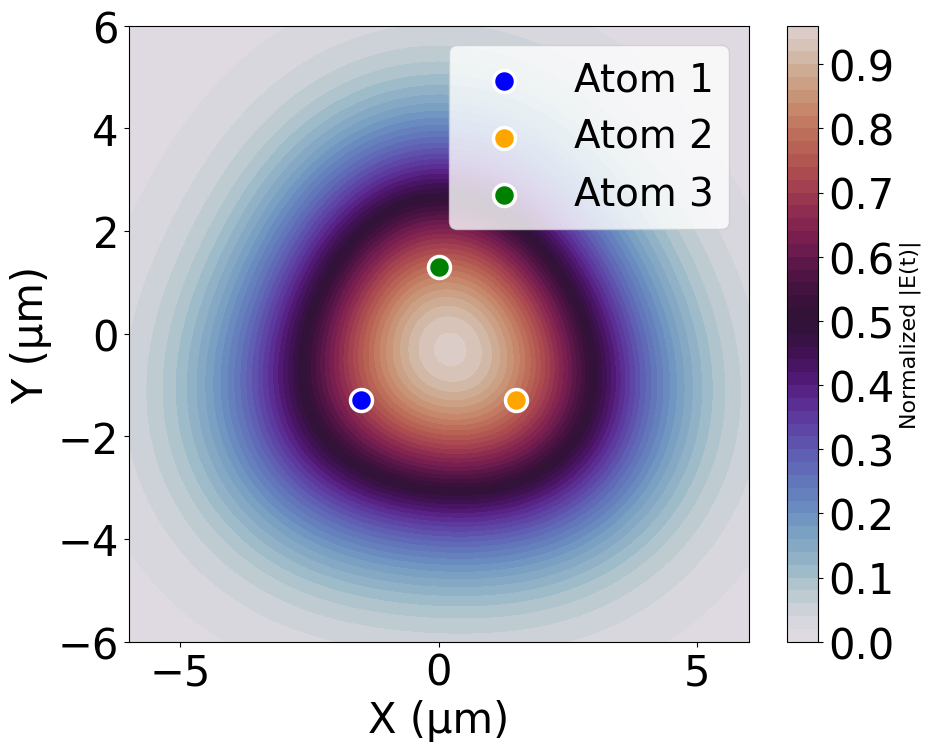

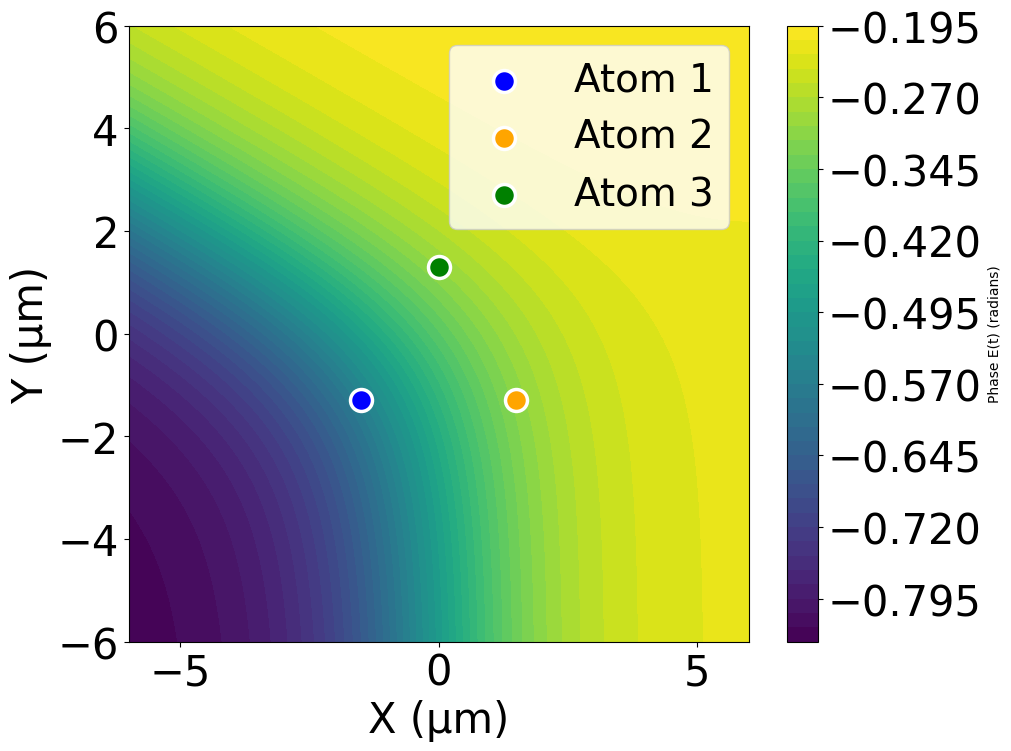

In [ ]:

# ========================================
# Part 5: main execution
# ========================================

# Main function to run the hybrid optimization
def run_multi_qubit_no_qoc():
    print(f" --- Initial Setups --- \n")

    # Laser intensity setup
    I_mW_per_cm2 = 20 # Laser intensity in mW/cm²
    Detuning_MHz = 1000  # 1 GHz detuning
    Omega_prefactor_MHz = calculate_Omega_rabi_prefactor(I_mW_per_cm2, Detuning_MHz)

    # Control system parameters
    m, n0, lambda_0 = 600, 1.95, 780e-9
    L = m * lambda_0 / n0
    a0, t0, a1, t1 = 0.998, 0.998, 0.998, 0.998

    # Define frequencies in MHz
    omega_0, omega_r = 6.835e3, 6.835e3

    # Time parameters [us]
    tmin = 0
    tmax_fixed = 0.1 #jnp.pi/30   # Fixed tmax in microseconds
    print(f"tmax_fixed : {tmax_fixed} us")
    t_steps = 100
    dt = (tmax_fixed - tmin) / t_steps

    # System and channel setup
    N_ch, N_scat_1, N_slm, N_ch_slm_in = 6, 4, 6, 4
    N_total = N_ch + N_scat_1
    N_scat_2, N_a = N_total - N_slm, 3


    # Crosstalk flag
    enable_crosstalk = False  # Set to True to enable crosstalk

    if enable_crosstalk:
        # Inter-channel waveguide distances
        base_distance = 1.0  # µm (nominal distance between adjacent waveguides)
        distance_variation = 0.1  # Random variation in distances (± µm)
        distances = generate_distances(N_ch, base_distance, random_variation=distance_variation, seed=42)

        # Coupling lengths
        base_coupling_length = 600.0  # µm (nominal coupling length for adjacent waveguides)
        length_variation = 60.0  # Random variation in coupling lengths (± µm)
        coupling_lengths = generate_coupling_lengths(N_ch, base_coupling_length, scaling_factor=1.1,
                                                      random_variation=length_variation, seed=42)

        # Effective refractive indices
        base_n_eff = 1.75  # Nominal effective refractive index
        n_eff_variation = 0.01  # Random variation in effective index (±)
        n_eff_list = generate_n_eff_list(N_ch, base_n_eff, random_variation=n_eff_variation, seed=42)

        # Waveguide-Coupling Parameters
        kappa0 = 10.145  # Maximum coupling coefficient at zero separation
        alpha = 6.934    # Coupling decay rate per µm

        print("Crosstalk parameters initialized:")
        print(f"Distances: {distances}")
        print(f"Coupling lengths: {coupling_lengths}")
        print(f"Effective refractive indices: {n_eff_list}")
        print(f"kappa0: {kappa0}, alpha: {alpha}")
    else:
        print("Crosstalk is disabled.")
        distances = None
        coupling_lengths = None
        n_eff_list = None
        kappa0 = None
        alpha = None

    # 2D atomic grid and atom positions
    atom_spacing = 3.0
    X, Y = generate_grid(grid_size=600, grid_range=(-6, 6))
    atom_positions = positions = generate_atom_positions_equilateral(N_a, side_length=atom_spacing, center=(0, 0))

    print(f"Atom positions: {atom_positions}, in [um]")

    # Beam and dipole parameters
    beam_centers, beam_waist = atom_positions, 2.0
    print(f"Beam centers: {beam_centers}, Beam waist: {beam_waist} in [um]")
    dipoles = generate_dipoles(N_a)

    # SLM modulation parameters
    phase_mod, amp_mod = generate_slm_mod(N_slm)

    # Weak scattering: pic inter-channel
    delta = 0.001

    # Control signal limits
    min_V_level, max_V_level = -15, 15

    # Initial fields
    a_pic = jnp.array([1.0] * N_ch)
    a_scat_1 = jnp.array([1.0] * N_scat_1)


    # Gaussian pulse parameters
    amplitude = 15.0  # Voltage amplitude
    center = (tmax_fixed - tmin) / 2  # Center of the pulse
    width = 0.01 # Width of the Gaussian pulse in microseconds
    omega_c = omega_0  # Carrier angular frequency

    # Select the gate type and generate target gate
    selected_atoms=[0]

    gate_type = 'single'
    if gate_type == 'single':
        U_target = program_instruction(N_a, key_number=1, gate_type=gate_type, selected_atoms=selected_atoms)

    print(f"U_target: {U_target}")

    # Amplitude scaling factors for each atom
    amplitude_scaling = [-0.004687414390425193, -0.474953520725683, 0.21494320033851505]  ### scaling factor from optimization

    # Generate control signals modulated by carrier frequency for each atom
    V0_no_qoc_list = []
    V1_no_qoc_list = []

    for atom_idx in range(N_a):  # Loop over all atoms
        V0_no_qoc = construct_V_no_qoc_with_carrier(
            tmin, tmax_fixed, t_steps, amplitude * amplitude_scaling[atom_idx], center, width, omega_c
        )
        V1_no_qoc = construct_V_no_qoc_with_carrier(
            tmin, tmax_fixed, t_steps, amplitude * amplitude_scaling[atom_idx], center, width, omega_c
        )
        V0_no_qoc_list.append(V0_no_qoc)
        V1_no_qoc_list.append(V1_no_qoc)

    # Fill the remaining channels with zero signals
    for _ in range(N_ch - N_a):  # Remaining unused channels
        V0_no_qoc_list.append(jnp.zeros(t_steps))
        V1_no_qoc_list.append(jnp.zeros(t_steps))

    # Convert lists to JAX arrays
    V0_no_qoc_list = jnp.array(V0_no_qoc_list)
    V1_no_qoc_list = jnp.array(V1_no_qoc_list)

    # Save initial control signals (optional)
    pd.DataFrame(V0_no_qoc_list).to_csv('V0_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')
    pd.DataFrame(V1_no_qoc_list).to_csv('V1_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')

    # Define parameter dictionaries
    APIC_params = {
        'L': L, 'n0': n0, 'lambda_0': lambda_0, 'a0': a0, 't0': t0,
        'a1': a1, 't1': t1, 'phase_mod': phase_mod, 'amp_mod': amp_mod
    }

    atom_beam_params = {
        'atom_positions': atom_positions, 'dipoles': dipoles,
        'a_pic': a_pic, 'a_scat_1': a_scat_1, 'beam_centers': beam_centers,
        'beam_waist': beam_waist, 'X': X, 'Y': Y, 'Omega_prefactor_MHz': Omega_prefactor_MHz,
    }

    control_Vt_params = {
        'tmin': tmin,
        'tmax': tmax_fixed,  # Fixed tmax
        't_steps': t_steps,
        'dt': dt,
        'min_V_level': min_V_level,
        'max_V_level': max_V_level
    }

    system_params = {
        'N_ch': N_ch, 'distances': distances,
        'coupling_lengths': coupling_lengths,
        'n_eff_list': n_eff_list,
        'enable_crosstalk': enable_crosstalk,
        'kappa0': kappa0, 'alpha': alpha,
        'N_slm': N_slm, 'N_ch_slm_in': N_ch_slm_in, 'N_scat_1': N_scat_1,
        'N_scat_2': N_scat_2, 'N_a': N_a, 'N_qubit_level': 2, 'omega_0': omega_0,
        'omega_r': omega_r, 'U_target': U_target, 'gate_type': gate_type, 'delta': delta
    }

    # Start optimization
    start_time = time.time()

    # classical control pulse, without QOC, use gaussian
    print("\n--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...")

    fidelity_gaussian, E_field_profiles, E_fields_at_atoms = compute_multi_qubit_fidelity_closed_system(
        V0_no_qoc_list, V1_no_qoc_list, APIC_params['L'], APIC_params['n0'],
        APIC_params['lambda_0'], APIC_params['a0'], APIC_params['t0'],
        APIC_params['a1'], APIC_params['t1'], APIC_params['phase_mod'],
        APIC_params['amp_mod'], system_params['delta'],
        atom_beam_params['atom_positions'], atom_beam_params['dipoles'],
        atom_beam_params['beam_centers'], atom_beam_params['beam_waist'],
        atom_beam_params['X'], atom_beam_params['Y'], atom_beam_params['Omega_prefactor_MHz'],
        control_Vt_params['tmin'], tmax_fixed,
        control_Vt_params['t_steps'], control_Vt_params['dt'],
        system_params['N_ch'], system_params['distances'], system_params['coupling_lengths'],
        system_params['n_eff_list'], system_params['kappa0'], system_params['alpha'],
        system_params['enable_crosstalk'],
        system_params['N_slm'], system_params['N_ch_slm_in'], system_params['N_scat_1'],
        system_params['N_scat_2'], system_params['N_a'],
        system_params['N_qubit_level'], system_params['omega_0'],
        system_params['omega_r'], atom_beam_params['a_pic'],
        atom_beam_params['a_scat_1'],
        system_params['U_target'], system_params['gate_type']
    )

    execution_time = (time.time() - start_time) / 60.0
    print(f"Simulation completed in {execution_time:.2f} minutes.")
    print(f"fidelity: {fidelity_gaussian:.10f}")

    # Time points
    time_points = jnp.linspace(tmin, tmax_fixed, t_steps)

    # Plot V(t) for all atoms in one figure
    fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)

    # Iterate through atoms and plot their V(t)
    for atom_idx in range(N_a):
        V_atom = V0_no_qoc_list[atom_idx]  # Extract the V(t) for the atom

        # Use different line styles and markers to distinguish overlapping plots
        if atom_idx == 1:  # Assuming atom 2 corresponds to index 1
            ax.plot(
                time_points,
                V_atom,
                label=f"Atom {atom_idx + 1}",
                linestyle='-',
                marker='o',
                markevery=50  # Add markers for visibility
            )
        elif atom_idx == 2:  # Assuming atom 3 corresponds to index 2
            ax.plot(
                time_points,
                V_atom,
                label=f"Atom {atom_idx + 1}",
                linestyle='--',
                marker='x',
                markevery=50  # Add markers for visibility
            )
        else:
            ax.plot(
                time_points,
                V_atom,
                label=f"Atom {atom_idx + 1}"
            )

    # Add labels, legend, and title
    ax.set_title("Control Voltage V(t) for All Atoms", fontsize=16)
    ax.set_xlabel("Time (µs)", fontsize=16)
    ax.set_ylabel("Voltage (V)", fontsize=16)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', labelsize=14)
    # ax.grid()  # Uncomment to add gridlines

    # Save and display the figure
    plt.savefig("Control_Vt_for_all_atoms_with_markers.png")
    plt.show()


    # Determine global min and max values for normalized amplitude
    E_magnitude_min = 0  # Normalized values are in [0, 1]
    E_magnitude_max = 1

    # Time indices to visualize (middle of the simulation)
    time_indices = [t_steps // 2]

    for t_idx in time_indices:
        E_profile = jnp.abs(E_field_profiles[t_idx])
        normalized_E_profile = (E_profile - jnp.min(E_field_profiles)) / (
            jnp.max(E_field_profiles) - jnp.min(E_field_profiles)
        )  # Normalize to [0, 1]

        # Normalized Magnitude profile
        plt.figure(figsize=(10, 8))
        contour = plt.contourf(
            X,
            Y,
            normalized_E_profile,
            levels=50,
            cmap="twilight", #"viridis",
            vmin=E_magnitude_min,
            vmax=E_magnitude_max,
        )
        #plt.colorbar(label="Normalized |E(t)|")
        colorbar = plt.colorbar(contour, label="Normalized |E(t)|")
        colorbar.ax.tick_params(labelsize=30)  # Adjust colorbar tick size
        colorbar.set_label("Normalized |E(t)|", fontsize=16)
        # Plot atom positions with enhanced visibility
        for i, pos in enumerate(atom_positions):
            plt.scatter(
                pos[0],
                pos[1],
                c=["blue", "orange", "green"][i % 3],  # Repeat colors for more than 3 atoms
                s=250,  # Increase marker size
                edgecolors="white",  # Add white edge
                linewidths=2.5,  # Thickness of the edge
                label=f"Atom {i + 1}",
            )

        #plt.title(f"Normalized E-field Magnitude Profile at t = {time_points[t_idx]:.2f} µs")
        plt.xlabel("X (µm)", fontsize=30)
        plt.ylabel("Y (µm)", fontsize=30)
        plt.tick_params(axis='both', labelsize=30)
        plt.legend(fontsize=28)
        plt.savefig(f"Normalized_E_field_magnitude_t{t_idx}.png")
        plt.show()

    # 3. Phase profile of E(t) at each time index (no normalization)
    for t_idx in time_indices:
        phase_profile = jnp.angle(E_field_profiles[t_idx])  # Compute phase

        plt.figure(figsize=(10, 8))
        contour = plt.contourf(X, Y, phase_profile, levels=50, cmap="viridis")
        colorbar = plt.colorbar(contour, label="Phase E(t) (radians)")
        colorbar.ax.tick_params(labelsize=30)  # Adjust colorbar tick size
        colorbar.set_label("Phase E(t) (radians)")
        # Plot atom positions with enhanced visibility
        for i, pos in enumerate(atom_positions):
            plt.scatter(
                pos[0],
                pos[1],
                c=["blue", "orange", "green"][i % 3],  # Repeat colors for more than 3 atoms
                s=250,  # Increase marker size
                edgecolors="white",  # Add white edge
                linewidths=2.5,  # Thickness of the edge
                label=f"Atom {i + 1}",
            )

        #plt.title(f"E-field Phase Profile at t = {time_points[t_idx]:.2f} µs")
        plt.xlabel("X (µm)", fontsize=30)
        plt.ylabel("Y (µm)", fontsize=30)
        plt.tick_params(axis='both', labelsize=30)
        plt.legend(fontsize=28)
        plt.savefig(f"E_field_phase_t{t_idx}.png")
        plt.show()


if __name__ == "__main__":
    run_multi_qubit_no_qoc()


# case 3: apply V(t) also on atom 2 and 3, with inter-channel crosstalk

### note: applied V(t) same as case 2




 --- Initial Setups --- 

Omega_prefactor_MHz: 7.679141521453857 

tmax_fixed : 0.1 us
Crosstalk parameters initialized:
Distances: [[0.         0.974908   2.090143   3.0463989  4.0197315  4.931204  ]
 [0.9311989  0.         0.91161674 2.0732353  3.020223   4.0416145 ]
 [1.9041169  1.093982   0.         1.0664885  1.9424678  2.936365  ]
 [2.9366808  1.9608485  1.0049512  0.         0.986389   1.9582459 ]
 [4.022371   2.927899   1.958429   0.9732724  0.         0.991214  ]
 [5.057035   3.9399347  3.002847   2.018483   0.9092901  0.        ]]
Coupling lengths: [[   0.       644.9448   780.0857   826.4393   890.299    925.02826]
 [ 618.71936    0.       606.97003  769.94116  810.7338   903.4287 ]
 [ 668.47015  716.38916    0.       699.8931   691.4807   760.419  ]
 [ 760.6085   702.5091   662.97076    0.       651.8334   700.9475 ]
 [ 891.8823   755.33923  701.0574   643.96344    0.       654.7284 ]
 [1000.5271   842.42084  800.3081   737.0897   605.57404    0.     ]]
Effective refractive

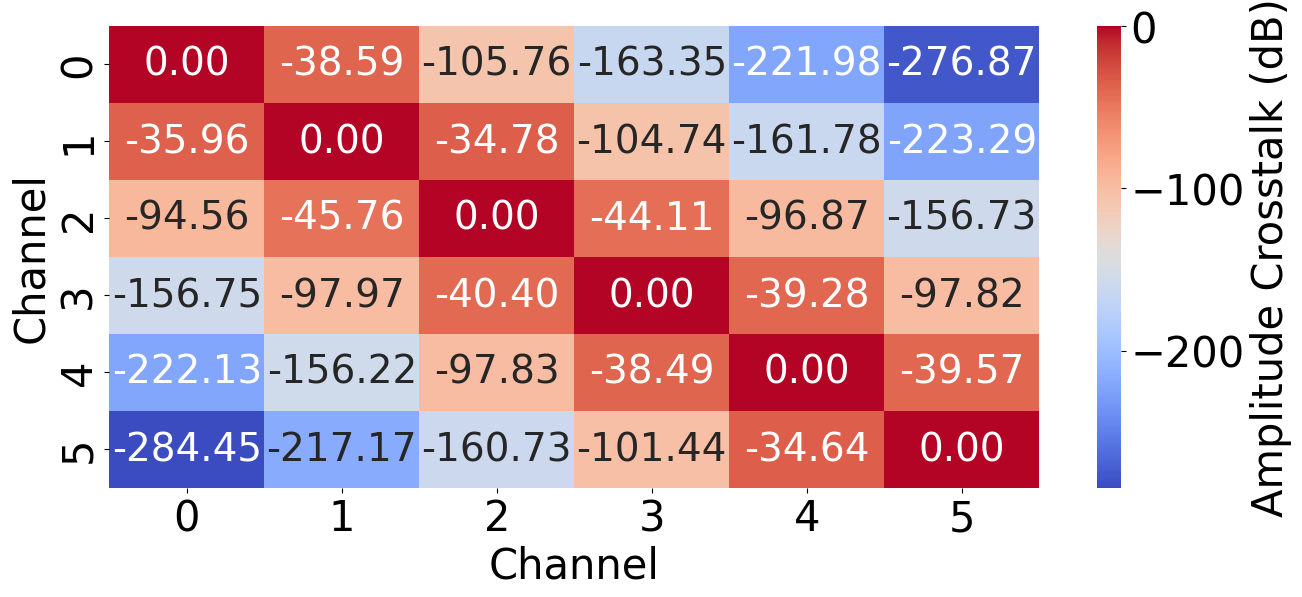

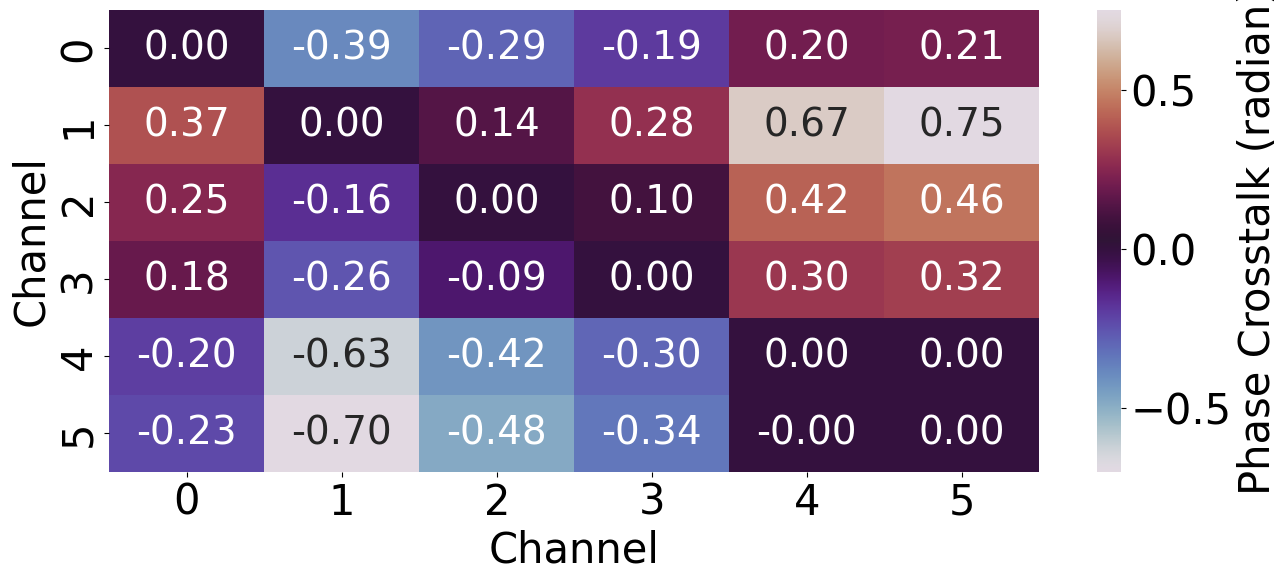

Atom positions: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], in [um]
Beam centers: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], Beam waist: 2.0 in [um]
Applying X gate to Atom 0
Applying Identity gate to Atom 1
Applying Identity gate to Atom 2
U_target: [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...
Simulation completed in 0.24 minutes.
fidelity: 0.0589308217


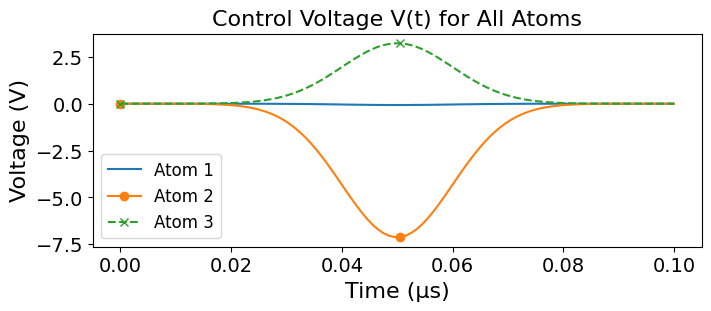

/usr/local/lib/python3.11/dist-packages/matplotlib/contour.py:1371: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/usr/local/lib/python3.11/dist-packages/matplotlib/contour.py:1372: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


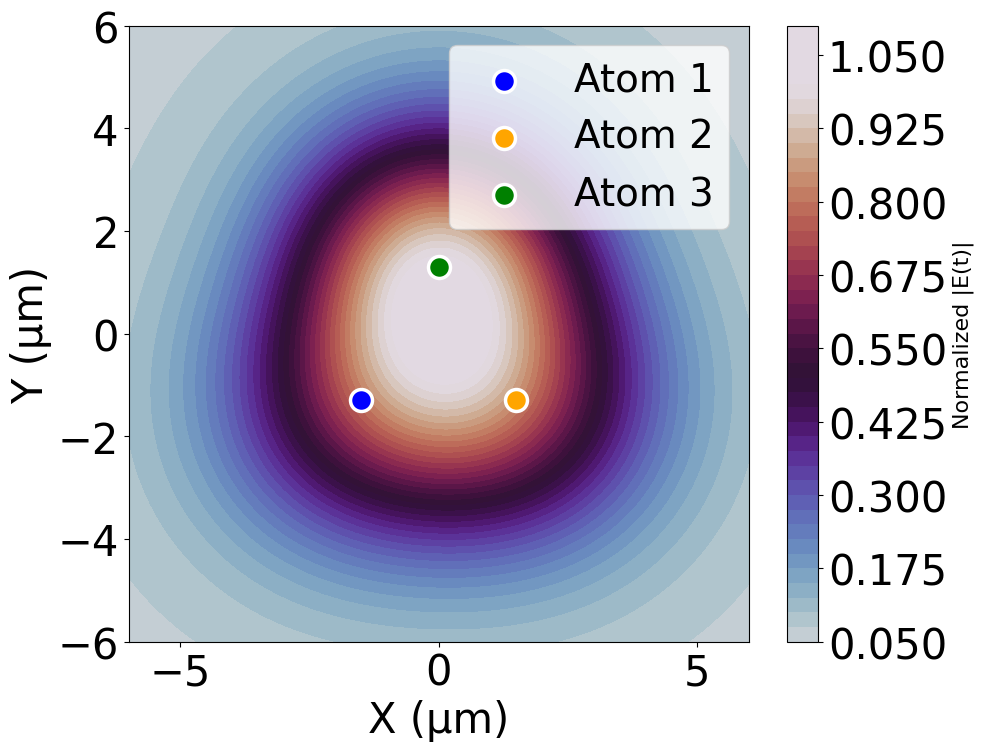

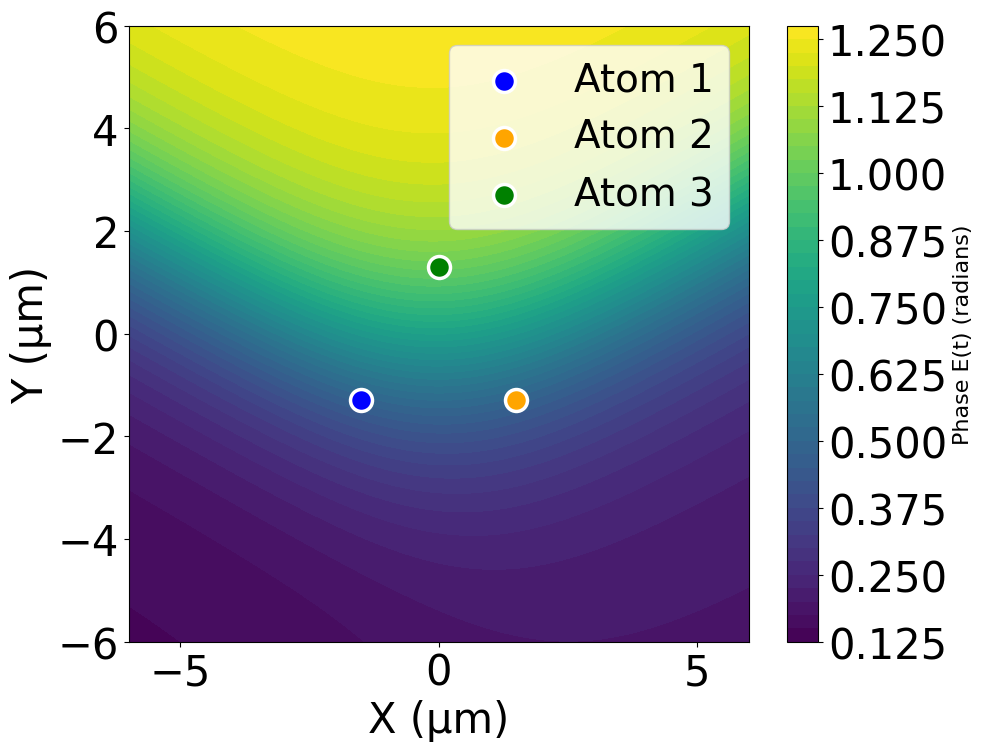

In [ ]:
import time
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # <--- Seaborn import

def run_multi_qubit_no_qoc():
    print(f" --- Initial Setups --- \n")

    # Laser intensity setup
    I_mW_per_cm2 = 20  # Laser intensity in mW/cm²
    Detuning_MHz = 1000  # 1 GHz detuning
    Omega_prefactor_MHz = calculate_Omega_rabi_prefactor(I_mW_per_cm2, Detuning_MHz)
    print(f"Omega_prefactor_MHz: {Omega_prefactor_MHz} \n")

    # Control system parameters
    m, n0, lambda_0 = 600, 1.95, 780e-9
    L = m * lambda_0 / n0
    a0, t0, a1, t1 = 0.998, 0.998, 0.998, 0.998

    # Define frequencies in MHz
    omega_0, omega_r = 6.835e3, 6.835e3

    # Time parameters [us]
    tmin = 0
    tmax_fixed = 0.1  # Fixed tmax in microseconds
    print(f"tmax_fixed : {tmax_fixed} us")
    t_steps = 100
    dt = (tmax_fixed - tmin) / t_steps

    # System and channel setup
    N_ch, N_scat_1, N_slm, N_ch_slm_in = 6, 4, 6, 4
    N_total = N_ch + N_scat_1
    N_scat_2, N_a = N_total - N_slm, 3

    # Crosstalk flag
    enable_crosstalk = True  # Set to True to enable crosstalk

    if enable_crosstalk:
        # Inter-channel waveguide distances
        base_distance = 1.0  # µm (nominal distance between adjacent waveguides)
        distance_variation = 0.1  # Random variation in distances (± µm)
        distances = generate_distances(N_ch, base_distance, random_variation=distance_variation, seed=42)

        # Coupling lengths
        base_coupling_length = 600.0  # µm (nominal)
        length_variation = 60.0       # ± µm variation
        coupling_lengths = generate_coupling_lengths(
            N_ch, base_coupling_length, scaling_factor=1.1,
            random_variation=length_variation, seed=42
        )

        # Effective refractive indices
        base_n_eff = 1.75
        n_eff_variation = 0.05  # ±
        n_eff_list = generate_n_eff_list(N_ch, base_n_eff, random_variation=n_eff_variation, seed=42)

        # Waveguide-Coupling Parameters
        kappa0 = 10.145  # Max coupling coefficient at zero separation
        alpha = 6.934    # Coupling decay rate per µm

        # Print crosstalk parameters
        print("Crosstalk parameters initialized:")
        print(f"Distances: {distances}")
        print(f"Coupling lengths: {coupling_lengths}")
        print(f"Effective refractive indices: {n_eff_list}")
        print(f"kappa0: {kappa0}, alpha: {alpha}")

        # Initialize crosstalk matrices as JAX arrays of zeros
        amplitude_ct_matrix = jnp.zeros((N_ch, N_ch), dtype=jnp.float32)
        phase_ct_matrix = jnp.zeros((N_ch, N_ch), dtype=jnp.float32)

        print("\n--- Crosstalk Strengths ---")
        for i in range(N_ch):
            for j in range(N_ch):
                if i != j:
                    distance_ij = distances[i, j]
                    if distance_ij > 0:
                        # Compute coupling coefficient
                        kappa_ij = kappa0 * jnp.exp(-alpha * distance_ij)
                        # Compute phase shift
                        phase_ct = (
                            2 * jnp.pi * coupling_lengths[i, j]
                            * (n_eff_list[i] - n_eff_list[j])
                            / base_coupling_length
                        )
                        # Convert amplitude crosstalk to dB
                        amplitude_ct_dB = 20 * jnp.log10(kappa_ij)

                        # Print out for debugging
                        print(f"Channel {i+1} -> Channel {j+1}:")
                        print(f"  Amplitude Crosstalk: {amplitude_ct_dB:.2f} dB")
                        print(f"  Phase Crosstalk: {phase_ct:.2f} radians")

                        # Store in matrices
                        amplitude_ct_matrix = amplitude_ct_matrix.at[i, j].set(amplitude_ct_dB)
                        phase_ct_matrix = phase_ct_matrix.at[i, j].set(phase_ct)

        # Convert JAX arrays to NumPy for plotting
        amplitude_ct_matrix = np.array(amplitude_ct_matrix)
        phase_ct_matrix = np.array(phase_ct_matrix)

        # Set diagonal entries to 0.0 (no self-crosstalk)
        np.fill_diagonal(amplitude_ct_matrix, 0.0)
        np.fill_diagonal(phase_ct_matrix, 0.0)

        # Plot Amplitude Crosstalk Heatmap (Seaborn)
        plt.figure(figsize=(15, 6))
        sns.heatmap(
            amplitude_ct_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            cbar_kws={'label': 'Amplitude CT (dB)', 'ticks': None},
            annot_kws={"fontsize": 28}
        )
        plt.xlabel("Channel", fontsize=30)
        plt.ylabel("Channel", fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        cbar = plt.gca().collections[0].colorbar
        cbar.ax.tick_params(labelsize=30)
        cbar.set_label("Amplitude Crosstalk (dB)", fontsize=30)
        plt.savefig("amplitude_crosstalk_heatmap.png")
        plt.show()

        # Plot Phase Crosstalk Heatmap (Seaborn)
        plt.figure(figsize=(15, 6))
        sns.heatmap(
            phase_ct_matrix,
            annot=True,
            fmt=".2f",
            cmap="twilight",
            cbar_kws={'label': 'Phase Crosstalk (radian)', 'ticks': None},
            annot_kws={"fontsize": 28}
        )
        plt.xlabel("Channel", fontsize=30)
        plt.ylabel("Channel", fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        cbar = plt.gca().collections[0].colorbar
        cbar.ax.tick_params(labelsize=30)
        cbar.set_label("Phase Crosstalk (radian)", fontsize=30)
        plt.savefig("phase_crosstalk_heatmap.png")
        plt.show()

    else:
        print("Crosstalk is disabled.")
        distances = None
        coupling_lengths = None
        n_eff_list = None
        kappa0 = None
        alpha = None

    # 2D atomic grid and atom positions
    atom_spacing = 3.0
    X, Y = generate_grid(grid_size=600, grid_range=(-6, 6))
    atom_positions = positions = generate_atom_positions_equilateral(N_a, side_length=atom_spacing, center=(0, 0))
    print(f"Atom positions: {atom_positions}, in [um]")

    # Beam and dipole parameters
    beam_centers, beam_waist = atom_positions, 2.0
    print(f"Beam centers: {beam_centers}, Beam waist: {beam_waist} in [um]")
    dipoles = generate_dipoles(N_a)

    # SLM modulation parameters
    phase_mod, amp_mod = generate_slm_mod(N_slm)

    # Weak scattering: pic inter-channel
    delta = 0.001

    # Control signal limits
    min_V_level, max_V_level = -15, 15

    # Initial fields
    a_pic = jnp.array([1.0] * N_ch)
    a_scat_1 = jnp.array([1.0] * N_scat_1)

    # Gaussian pulse parameters
    amplitude = 15.0
    center = (tmax_fixed - tmin) / 2
    width = 0.01
    omega_c = omega_0

    # Select the gate type and generate target gate
    selected_atoms = [0]
    gate_type = 'single'
    if gate_type == 'single':
        U_target = program_instruction(N_a, key_number=1, gate_type=gate_type, selected_atoms=selected_atoms)
    print(f"U_target: {U_target}")

    # amplitude scaling factors for each atom
    amplitude_scaling = [-0.004687414390425193, -0.474953520725683, 0.21494320033851505]

    # Generate control signals modulated by carrier frequency for each atom
    V0_no_qoc_list = []
    V1_no_qoc_list = []
    for atom_idx in range(N_a):
        V0_no_qoc = construct_V_no_qoc_with_carrier(
            tmin, tmax_fixed, t_steps,
            amplitude * amplitude_scaling[atom_idx],
            center, width, omega_c
        )
        V1_no_qoc = construct_V_no_qoc_with_carrier(
            tmin, tmax_fixed, t_steps,
            amplitude * amplitude_scaling[atom_idx],
            center, width, omega_c
        )
        V0_no_qoc_list.append(V0_no_qoc)
        V1_no_qoc_list.append(V1_no_qoc)

    # Fill remaining channels with zero signals
    for _ in range(N_ch - N_a):
        V0_no_qoc_list.append(jnp.zeros(t_steps))
        V1_no_qoc_list.append(jnp.zeros(t_steps))

    # Convert lists to JAX arrays
    V0_no_qoc_list = jnp.array(V0_no_qoc_list)
    V1_no_qoc_list = jnp.array(V1_no_qoc_list)

    # Optionally save initial control signals
    pd.DataFrame(V0_no_qoc_list).to_csv('V0_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')
    pd.DataFrame(V1_no_qoc_list).to_csv('V1_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')

    # Define parameter dictionaries
    APIC_params = {
        'L': L, 'n0': n0, 'lambda_0': lambda_0, 'a0': a0, 't0': t0,
        'a1': a1, 't1': t1, 'phase_mod': phase_mod, 'amp_mod': amp_mod
    }

    atom_beam_params = {
        'atom_positions': atom_positions, 'dipoles': dipoles,
        'a_pic': a_pic, 'a_scat_1': a_scat_1, 'beam_centers': beam_centers,
        'beam_waist': beam_waist, 'X': X, 'Y': Y, 'Omega_prefactor_MHz': Omega_prefactor_MHz,
    }

    control_Vt_params = {
        'tmin': tmin,
        'tmax': tmax_fixed,
        't_steps': t_steps,
        'dt': dt,
        'min_V_level': min_V_level,
        'max_V_level': max_V_level
    }

    system_params = {
        'N_ch': N_ch,
        'distances': distances,
        'coupling_lengths': coupling_lengths,
        'n_eff_list': n_eff_list,
        'enable_crosstalk': enable_crosstalk,
        'kappa0': kappa0,
        'alpha': alpha,
        'N_slm': N_slm,
        'N_ch_slm_in': N_ch_slm_in,
        'N_scat_1': N_scat_1,
        'N_scat_2': N_scat_2,
        'N_a': N_a,
        'N_qubit_level': 2,
        'omega_0': omega_0,
        'omega_r': omega_r,
        'U_target': U_target,
        'gate_type': gate_type,
        'delta': 0.001
    }

    # Start "no QOC" simulation
    start_time = time.time()
    print("\n--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...")

    fidelity_gaussian, E_field_profiles, E_fields_at_atoms = compute_multi_qubit_fidelity_closed_system(
        V0_no_qoc_list, V1_no_qoc_list,
        APIC_params['L'], APIC_params['n0'], APIC_params['lambda_0'],
        APIC_params['a0'], APIC_params['t0'], APIC_params['a1'], APIC_params['t1'],
        APIC_params['phase_mod'], APIC_params['amp_mod'], system_params['delta'],
        atom_beam_params['atom_positions'], atom_beam_params['dipoles'],
        atom_beam_params['beam_centers'], atom_beam_params['beam_waist'],
        atom_beam_params['X'], atom_beam_params['Y'], atom_beam_params['Omega_prefactor_MHz'],
        control_Vt_params['tmin'], tmax_fixed,
        control_Vt_params['t_steps'], control_Vt_params['dt'],
        system_params['N_ch'], system_params['distances'], system_params['coupling_lengths'],
        system_params['n_eff_list'], system_params['kappa0'], system_params['alpha'],
        system_params['enable_crosstalk'],
        system_params['N_slm'], system_params['N_ch_slm_in'], system_params['N_scat_1'],
        system_params['N_scat_2'], system_params['N_a'],
        system_params['N_qubit_level'], system_params['omega_0'],
        system_params['omega_r'], atom_beam_params['a_pic'],
        atom_beam_params['a_scat_1'],
        system_params['U_target'], system_params['gate_type']
    )

    execution_time = (time.time() - start_time) / 60.0
    print(f"Simulation completed in {execution_time:.2f} minutes.")
    print(f"fidelity: {fidelity_gaussian:.10f}")

    # Time points
    time_points = jnp.linspace(tmin, tmax_fixed, t_steps)

    # 1) Plot V(t) for all atoms in one figure
    fig, ax = plt.subplots(figsize=(7, 3), constrained_layout=True)
    for atom_idx in range(N_a):
        V_atom = V0_no_qoc_list[atom_idx]
        if atom_idx == 1:
            ax.plot(
                time_points, V_atom,
                label=f"Atom {atom_idx + 1}",
                linestyle='-', marker='o', markevery=50
            )
        elif atom_idx == 2:
            ax.plot(
                time_points, V_atom,
                label=f"Atom {atom_idx + 1}",
                linestyle='--', marker='x', markevery=50
            )
        else:
            ax.plot(time_points, V_atom, label=f"Atom {atom_idx + 1}")

    ax.set_title("Control Voltage V(t) for All Atoms", fontsize=16)
    ax.set_xlabel("Time (µs)", fontsize=16)
    ax.set_ylabel("Voltage (V)", fontsize=16)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', labelsize=14)
    plt.savefig("Control_Vt_for_all_atoms_with_markers.png")
    plt.show()

    # 3) 2D profile at a chosen time index
    time_indices = [t_steps // 2]
    for t_idx in time_indices:
        E_profile = jnp.abs(E_field_profiles[t_idx])
        normalized_E_profile = (E_profile - jnp.min(E_field_profiles)) / (
            jnp.max(E_field_profiles) - jnp.min(E_field_profiles)
        )

        plt.figure(figsize=(10, 8))
        contour = plt.contourf(
            X, Y, normalized_E_profile,
            levels=50, cmap="twilight", vmin=0, vmax=1
        )
        colorbar = plt.colorbar(contour, label="Normalized |E(t)|")
        colorbar.ax.tick_params(labelsize=30)
        colorbar.set_label("Normalized |E(t)|", fontsize=16)
        for i, pos in enumerate(atom_positions):
            plt.scatter(
                pos[0], pos[1],
                c=["blue", "orange", "green"][i % 3],
                s=250, edgecolors="white", linewidths=2.5,
                label=f"Atom {i + 1}"
            )
        plt.xlabel("X (µm)", fontsize=30)
        plt.ylabel("Y (µm)", fontsize=30)
        plt.tick_params(axis='both', labelsize=30)
        plt.legend(fontsize=28)
        plt.savefig(f"Normalized_E_field_magnitude_t{t_idx}.png")
        plt.show()

    # 4) Phase profile
    for t_idx in time_indices:
        phase_profile = jnp.angle(E_field_profiles[t_idx])
        plt.figure(figsize=(10, 8))
        contour = plt.contourf(X, Y, phase_profile, levels=50, cmap="viridis")
        colorbar = plt.colorbar(contour, label="Phase E(t) (radians)")
        colorbar.ax.tick_params(labelsize=30)
        colorbar.set_label("Phase E(t) (radians)", fontsize=16)
        for i, pos in enumerate(atom_positions):
            plt.scatter(
                pos[0], pos[1],
                c=["blue", "orange", "green"][i % 3],
                s=250, edgecolors="white", linewidths=2.5,
                label=f"Atom {i + 1}"
            )
        plt.xlabel("X (µm)", fontsize=30)
        plt.ylabel("Y (µm)", fontsize=30)
        plt.tick_params(axis='both', labelsize=30)
        plt.legend(fontsize=28)
        plt.savefig(f"E_field_phase_t{t_idx}.png")
        plt.show()


if __name__ == "__main__":
    run_multi_qubit_no_qoc()

# plot fidelities for all 3 cases

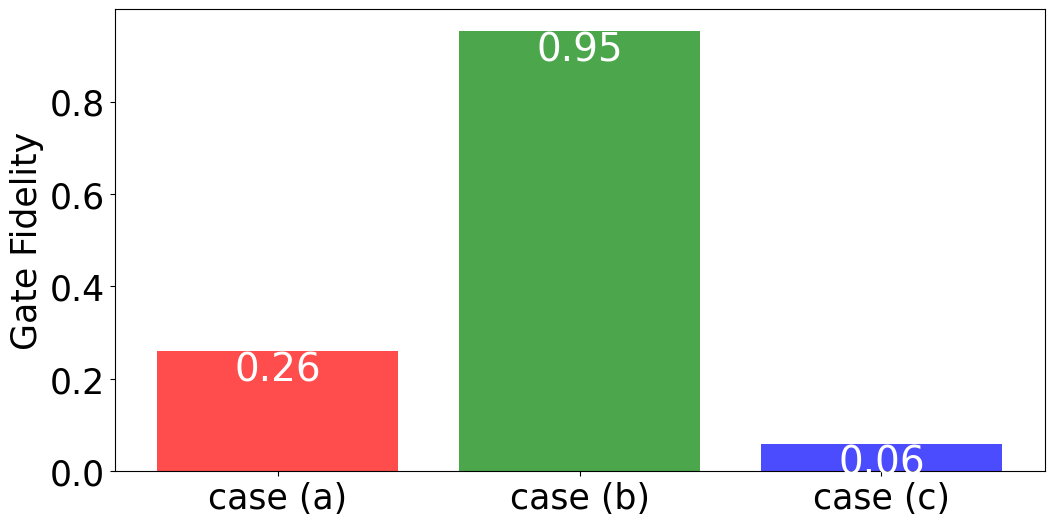

In [ ]:
import matplotlib.pyplot as plt

# Data
cases = ["case (a)", "case (b)", "case (c)"]
fidelities = [0.2606960833, 0.9521383643, 0.0589308217]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(cases, fidelities, color=['red', 'green', 'blue'], alpha=0.7)

# Add value annotations on the bars
for bar, fidelity in zip(bars, fidelities):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{fidelity:.3f}", ha="center", va="top", fontsize=28, color='white')

# Customize axes and labels
plt.ylabel("Gate Fidelity", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Save and show
plt.savefig("Gate_Fidelity_Cases.png")
plt.show()

# Appendix case 2: optimize fidelity w.r.t. scaling factors of all atoms

In [ ]:
import time
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import differential_evolution, minimize

def run_multi_qubit_no_qoc():
    print(f" --- Initial Setups --- \n")

    # Laser intensity setup and other parameters
    I_mW_per_cm2 = 20  # mW/cm²
    Detuning_MHz = 1000  # 1 GHz detuning
    Omega_prefactor_MHz = calculate_Omega_rabi_prefactor(I_mW_per_cm2, Detuning_MHz)

    m, n0, lambda_0 = 600, 1.95, 780e-9
    L = m * lambda_0 / n0
    a0, t0, a1, t1 = 0.998, 0.998, 0.998, 0.998

    omega_0, omega_r = 6.835e3, 6.835e3

    tmin = 0
    tmax_fixed = 0.1  # microseconds
    print(f"tmax_fixed : {tmax_fixed} us")
    t_steps = 100
    dt = (tmax_fixed - tmin) / t_steps

    N_ch, N_scat_1, N_slm, N_ch_slm_in = 6, 4, 6, 4
    N_total = N_ch + N_scat_1
    N_scat_2, N_a = N_total - N_slm, 3

    enable_crosstalk = False  # Set to True to enable crosstalk effects
    if enable_crosstalk:
        # Inter-channel waveguide distances
        base_distance = 1.0  # µm (nominal distance between adjacent waveguides)
        distance_variation = 0.1  # Random variation in distances (± µm)
        distances = generate_distances(N_ch, base_distance, random_variation=distance_variation, seed=42)

        # Coupling lengths for adjacent waveguides
        base_coupling_length = 600.0  # µm (nominal coupling length)
        length_variation = 60.0  # Random variation in coupling lengths (± µm)
        coupling_lengths = generate_coupling_lengths(N_ch, base_coupling_length, scaling_factor=1.1,
                                                     random_variation=length_variation, seed=42)

        # Effective refractive indices
        base_n_eff = 1.75  # Nominal effective refractive index
        n_eff_variation = 0.01  # Random variation in effective index (±)
        n_eff_list = generate_n_eff_list(N_ch, base_n_eff, random_variation=n_eff_variation, seed=42)

        # Waveguide-Coupling Parameters
        kappa0 = 10.145  # Maximum coupling coefficient at zero separation
        alpha = 6.934    # Coupling decay rate per µm

        print("Crosstalk parameters initialized:")
        print(f"Distances: {distances}")
        print(f"Coupling lengths: {coupling_lengths}")
        print(f"Effective refractive indices: {n_eff_list}")
        print(f"kappa0: {kappa0}, alpha: {alpha}")
    else:
        print("Crosstalk is disabled.")
        distances = None
        coupling_lengths = None
        n_eff_list = None
        kappa0 = None
        alpha = None

    atom_spacing = 3.0
    X, Y = generate_grid(grid_size=600, grid_range=(-6, 6))
    atom_positions = generate_atom_positions_equilateral(N_a, side_length=atom_spacing, center=(0, 0))
    print(f"Atom positions: {atom_positions}, in [um]")

    beam_centers, beam_waist = atom_positions, 2.0
    print(f"Beam centers: {beam_centers}, Beam waist: {beam_waist} in [um]")
    dipoles = generate_dipoles(N_a)
    phase_mod, amp_mod = generate_slm_mod(N_slm)
    delta = 0.001

    min_V_level, max_V_level = -15, 15
    a_pic = jnp.array([1.0] * N_ch)
    a_scat_1 = jnp.array([1.0] * N_scat_1)

    amplitude = 15.0  # Voltage amplitude
    center = (tmax_fixed - tmin) / 2
    width = 0.01  # microseconds
    omega_c = omega_0

    selected_atoms = [0]
    gate_type = 'single'
    if gate_type == 'single':
        U_target = program_instruction(N_a, key_number=1, gate_type=gate_type, selected_atoms=selected_atoms)
    print(f"U_target: {U_target}")

    # Helper: build control signals given scaling factors for all atoms.
    def build_control_signals(amplitude_scaling):
        V0_no_qoc_list = []
        V1_no_qoc_list = []
        for atom_idx in range(N_a):
            V0_no_qoc = construct_V_no_qoc_with_carrier(
                tmin, tmax_fixed, t_steps, amplitude * amplitude_scaling[atom_idx],
                center, width, omega_c
            )
            V1_no_qoc = construct_V_no_qoc_with_carrier(
                tmin, tmax_fixed, t_steps, amplitude * amplitude_scaling[atom_idx],
                center, width, omega_c
            )
            V0_no_qoc_list.append(V0_no_qoc)
            V1_no_qoc_list.append(V1_no_qoc)
        for _ in range(N_ch - N_a):
            V0_no_qoc_list.append(jnp.zeros(t_steps))
            V1_no_qoc_list.append(jnp.zeros(t_steps))
        return jnp.array(V0_no_qoc_list), jnp.array(V1_no_qoc_list)

    # Objective function: optimize scaling factors for all three atoms.
    def fidelity_objective(params):
        # params[0] for atom 1, params[1] for atom 2, params[2] for atom 3.
        amplitude_scaling = [params[0], params[1], params[2]]
        V0_no_qoc_list, V1_no_qoc_list = build_control_signals(amplitude_scaling)
        fidelity, _, _ = compute_multi_qubit_fidelity_closed_system(
            V0_no_qoc_list, V1_no_qoc_list,
            L, n0, lambda_0, a0, t0, a1, t1,
            phase_mod, amp_mod, delta,
            atom_positions, dipoles,
            beam_centers, beam_waist,
            X, Y, Omega_prefactor_MHz,
            tmin, tmax_fixed, t_steps, dt,
            N_ch, distances, coupling_lengths,
            n_eff_list, kappa0, alpha,
            enable_crosstalk,
            N_slm, N_ch_slm_in, N_scat_1,
            N_scat_2, N_a,
            2, omega_0, omega_r,
            a_pic, a_scat_1,
            U_target, gate_type
        )
        # If fidelity >= 1.0, apply a penalty.
        if fidelity >= 1.0:
            error = 1e6
            print("Solution with fidelity >= 1.0 detected; assigning penalty error.")
        else:
            error = (1.0 - fidelity)**2
        print(f"Testing scaling: {amplitude_scaling} -> fidelity: {fidelity:.6f}, error: {error:.6e}")
        return error

    # Callback function for differential evolution:
    # Stop if current fidelity > 0.95 and < 1.0.
    def de_callback(xk, convergence):
        amplitude_scaling = [xk[0], xk[1], xk[2]]
        V0, V1 = build_control_signals(amplitude_scaling)
        fidelity, _, _ = compute_multi_qubit_fidelity_closed_system(
            V0, V1,
            L, n0, lambda_0, a0, t0, a1, t1,
            phase_mod, amp_mod, delta,
            atom_positions, dipoles,
            beam_centers, beam_waist,
            X, Y, Omega_prefactor_MHz,
            tmin, tmax_fixed, t_steps, dt,
            N_ch, distances, coupling_lengths,
            n_eff_list, kappa0, alpha,
            enable_crosstalk,
            N_slm, N_ch_slm_in, N_scat_1,
            N_scat_2, N_a,
            2, omega_0, omega_r,
            a_pic, a_scat_1,
            U_target, gate_type
        )
        print(f"DE callback: current fidelity = {fidelity:.6f}")
        if fidelity > 0.95 and fidelity < 1.0:
            print("Desired fidelity > 0.95 reached; stopping DE.")
            return True
        return False

    # --- Global Optimization Phase ---
    bounds = [(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
    de_result = differential_evolution(
        fidelity_objective, bounds=bounds,
        strategy='best1bin', maxiter=1000,
        popsize=15, tol=1e-6, disp=True,
        callback=de_callback
    )
    best_de_scaling = de_result.x
    de_fidelity = 1.0 - (de_result.fun ** 0.5)
    print(f"\n[Global] Best scaling factors from DE: {best_de_scaling}")
    print(f"[Global] Fidelity from DE: {de_fidelity:.6f}")

    # --- Local Refinement Phase ---
    if de_fidelity < 0.95:
        local_result = minimize(
            fidelity_objective, best_de_scaling,
            bounds=bounds, method='L-BFGS-B',
            options={'ftol': 1e-12, 'maxiter': 1000}
        )
        optimal_scaling = local_result.x
        best_fidelity = 1.0 - (local_result.fun ** 0.5)
        print(f"\n[Local] Optimal scaling factors: {optimal_scaling}")
        print(f"[Local] Best fidelity achieved: {best_fidelity:.6f}")
    else:
        optimal_scaling = best_de_scaling
        best_fidelity = de_fidelity
        print("\n[Global] Fidelity > 0.95 reached; skipping local refinement.")

    amplitude_scaling = optimal_scaling.tolist()
    V0_no_qoc_list, V1_no_qoc_list = build_control_signals(amplitude_scaling)

    pd.DataFrame(V0_no_qoc_list).to_csv('V0_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')
    pd.DataFrame(V1_no_qoc_list).to_csv('V1_noqoc_multi_qubit_withCT_3sQ_dwg_0p6um.csv', index_label='Channel')

    APIC_params = {
        'L': L, 'n0': n0, 'lambda_0': lambda_0, 'a0': a0, 't0': t0,
        'a1': a1, 't1': t1, 'phase_mod': phase_mod, 'amp_mod': amp_mod
    }
    atom_beam_params = {
        'atom_positions': atom_positions, 'dipoles': dipoles,
        'a_pic': a_pic, 'a_scat_1': a_scat_1, 'beam_centers': beam_centers,
        'beam_waist': beam_waist, 'X': X, 'Y': Y, 'Omega_prefactor_MHz': Omega_prefactor_MHz,
    }
    control_Vt_params = {
        'tmin': tmin, 'tmax': tmax_fixed, 't_steps': t_steps, 'dt': dt,
        'min_V_level': min_V_level, 'max_V_level': max_V_level
    }
    system_params = {
        'N_ch': N_ch, 'distances': distances,
        'coupling_lengths': coupling_lengths,
        'n_eff_list': n_eff_list,
        'enable_crosstalk': enable_crosstalk,
        'kappa0': kappa0, 'alpha': alpha,
        'N_slm': N_slm, 'N_ch_slm_in': N_ch_slm_in, 'N_scat_1': N_scat_1,
        'N_scat_2': N_scat_2, 'N_a': N_a, 'N_qubit_level': 2,
        'omega_0': omega_0, 'omega_r': omega_r, 'U_target': U_target,
        'gate_type': gate_type, 'delta': delta
    }

    # Run the final simulation.
    start_time = time.time()
    print("\n--- Starting multi-qubit gate no qoc, gaussian pulse, with CrossTalk...")

    fidelity_gaussian, E_field_profiles, E_fields_at_atoms = compute_multi_qubit_fidelity_closed_system(
        V0_no_qoc_list, V1_no_qoc_list,
        APIC_params['L'], APIC_params['n0'], APIC_params['lambda_0'],
        APIC_params['a0'], APIC_params['t0'], APIC_params['a1'], APIC_params['t1'],
        APIC_params['phase_mod'], APIC_params['amp_mod'], system_params['delta'],
        atom_beam_params['atom_positions'], atom_beam_params['dipoles'],
        atom_beam_params['beam_centers'], atom_beam_params['beam_waist'],
        atom_beam_params['X'], atom_beam_params['Y'], atom_beam_params['Omega_prefactor_MHz'],
        control_Vt_params['tmin'], tmax_fixed,
        control_Vt_params['t_steps'], control_Vt_params['dt'],
        system_params['N_ch'], system_params['distances'], system_params['coupling_lengths'],
        system_params['n_eff_list'], system_params['kappa0'], system_params['alpha'],
        system_params['enable_crosstalk'],
        system_params['N_slm'], system_params['N_ch_slm_in'], system_params['N_scat_1'],
        system_params['N_scat_2'], system_params['N_a'],
        system_params['N_qubit_level'], system_params['omega_0'],
        system_params['omega_r'], atom_beam_params['a_pic'],
        atom_beam_params['a_scat_1'],
        system_params['U_target'], system_params['gate_type']
    )

    execution_time = (time.time() - start_time) / 60.0
    print(f"Simulation completed in {execution_time:.2f} minutes.")
    print(f"fidelity: {fidelity_gaussian:.10f}")

if __name__ == "__main__":
    run_multi_qubit_no_qoc()

 --- Initial Setups --- 

Omega_prefactor_MHz: 7.679141521453857 

tmax_fixed : 0.1
Chosen dt: 1.00 ns
Crosstalk is disabled.
Atom positions: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], in [um]
Beam centers: [(-1.5, -1.299038105676658), (1.5, -1.299038105676658), (0.0, 1.299038105676658)], Beam waist: 2.0 in [um]
Applying X gate to Atom 0
Applying Identity gate to Atom 1
Applying Identity gate to Atom 2
U_target: [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
Diagonal of U_system_multi_channel[0]: [-0.00016505+0.01285876j -0.0001